# 1. Notebook Introduction
This notebook provides a complete pipeline to train and evaluate a multi-task (depth prediction + semantic segmentation) model by applying knowledge distillation.
The student's architecture is a Unet with a ResNet18 backbone and the teacher will be one of the biggest Depth Anything V3 model (DA3NESTED-GIANT-LARGE).
The training stage is tracked with MLFlow and the best set of hyperparameters are found by an Optuna study.

# 2. Imports and Setup

In [1]:
import os
import gc
import joblib
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import segmentation_models_pytorch as smp
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from collections import defaultdict

import mlflow
from mlflow.tracking import MlflowClient
import optuna
import optuna.visualization as viz
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.loggers import MLFlowLogger

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Seed set to 42


Using device: cuda


# 3. Classes and Definitions

## 3.1 Dataset Class
Custom dataset class. It implements manual HorizontalFlip and ColorJitter transformations, so they can be applied not only to the input images but also to the Teacher's depth maps and to the ground truth segmentation masks (only HorizontalFlip).

In [2]:
class DepthDistillationDataset(Dataset):
    """Optimized dataset that loads pre-processed numpy masks."""
    
    def __init__(self, img_dir, depth_dir, seg_dir, num_classes, is_train=False, prob=None):
        self.img_dir = img_dir
        self.depth_dir = depth_dir
        self.seg_dir = seg_dir
        self.num_classes = num_classes
        self.is_train = is_train
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        base_name = img_name.replace('.png', '')
        
        # Load image
        image = Image.open(os.path.join(self.img_dir, img_name)).convert('RGB')
        
        # Load depth
        teacher_depth = np.load(os.path.join(self.depth_dir, f"{base_name}.npy"))

        # Load pre-processed segmentation mask (already class IDs!)
        seg_mask = np.load(os.path.join(self.seg_dir, f"{base_name}.npy"))
        
        # Augmentations
        if self.is_train:
            if torch.rand(1).item() < self.prob['horizontal_flip']:
                image = TF.hflip(image)
                teacher_depth = np.fliplr(teacher_depth).copy()
                seg_mask = np.fliplr(seg_mask).copy()
            
            if torch.rand(1).item() < self.prob['color_jitter']:
                image = T.ColorJitter(brightness=0.25, contrast=0.25)(image)
        
        # To tensors
        image = TF.to_tensor(image)
        image = TF.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        teacher_depth = torch.from_numpy(teacher_depth).float()
        seg_mask = torch.from_numpy(seg_mask.copy()).long()
        
        return image, teacher_depth, seg_mask

## 3.2 Data Module Class

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_img_dir, train_depth_dir, train_seg_dir,
                 val_img_dir, val_depth_dir, val_seg_dir,
                 test_img_dir, test_depth_dir, test_seg_dir,
                 num_classes=32,
                 batch_size=4, 
                 num_workers=2,
                 prob=None):
        """
        Args:
            train_img_dir, train_depth_dir, train_seg_dir: Training data directories
            val_img_dir, val_depth_dir, val_seg_dir: Validation data directories
            test_img_dir, test_depth_dir, test_seg_dir: Test data directories
            batch_size: Batch size for dataloaders
            num_workers: Number of workers for dataloaders
            prob: Dictionary with augmentation probabilities
        """
        super().__init__()
        self.train_img_dir = train_img_dir
        self.train_depth_dir = train_depth_dir
        self.train_seg_dir = train_seg_dir
        self.val_img_dir = val_img_dir
        self.val_depth_dir = val_depth_dir
        self.val_seg_dir = val_seg_dir
        self.test_img_dir = test_img_dir
        self.test_depth_dir = test_depth_dir
        self.test_seg_dir = test_seg_dir
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.prob = prob if prob is not None else {'horizontal_flip': 0.5, 'color_jitter': 0.5}
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dataset = DepthDistillationDataset(
                img_dir=self.train_img_dir,
                depth_dir=self.train_depth_dir,
                seg_dir=self.train_seg_dir,
                num_classes=self.num_classes,
                is_train=True,
                prob=self.prob
            )
            self.val_dataset = DepthDistillationDataset(
                img_dir=self.val_img_dir,
                depth_dir=self.val_depth_dir,
                seg_dir=self.val_seg_dir,
                num_classes=self.num_classes,
                is_train=False
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = DepthDistillationDataset(
                img_dir=self.test_img_dir,
                depth_dir=self.test_depth_dir,
                seg_dir=self.test_seg_dir,
                num_classes=self.num_classes,
                is_train=False
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )

## 3.3 Depth + Segmentation Loss Function

Loss function that basically aggregates the loss used for depth prediction (MSE loss) and the loss used for semantic segmentation (cross-entropy loss). Instead of just adding both losses or weighting them by manually selected values, we used the implementation suggested by Alex Kendall and its collegues (https://arxiv.org/pdf/1705.07115), where the actual weights of the separate loss functions are just another set of learnable parameters.

In [4]:
class DepthSegMultiTaskLoss(nn.Module):
    """
    Multi-task loss with learnable uncertainty weighting.
    Based on "Multi-Task Learning Using Uncertainty to Weigh Losses" (Kendall et al., 2018)
    """
    def __init__(self, init_log_var_depth=0.0, init_log_var_seg=0.0):
        super().__init__()
        self.log_var_depth = nn.Parameter(torch.tensor(init_log_var_depth))
        self.log_var_seg = nn.Parameter(torch.tensor(init_log_var_seg))
        
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, depth_pred, depth_target, seg_pred, seg_target):
        # Ensure correct shapes
        if depth_pred.dim() == 4:
            depth_pred = depth_pred.squeeze(1)
        
        # Task losses
        depth_loss = self.mse_loss(depth_pred, depth_target)
        seg_loss = self.ce_loss(seg_pred, seg_target)
        
        # Uncertainty weighting
        # precision = 1/σ², using log_var = log(σ²) for stability
        precision_depth = torch.exp(-self.log_var_depth)
        precision_seg = torch.exp(-self.log_var_seg)
        
        weighted_depth = 0.5 * precision_depth * depth_loss + 0.5 * self.log_var_depth
        weighted_seg = 0.5 * precision_seg * seg_loss + 0.5 * self.log_var_seg
        
        total_loss = weighted_depth + weighted_seg
        
        # Return individual losses for logging
        return {
            'total_loss': total_loss,
            'depth_loss': depth_loss,
            'seg_loss': seg_loss,
            'weight_depth': precision_depth.detach(),
            'weight_seg': precision_seg.detach()
        }

## 3.4 Lightning Module

In [5]:
class DepthSegDistillationModule(pl.LightningModule):
    def __init__(self, student_model, lr=3e-4, weight_decay=0.0):
        super().__init__()
        self.student = student_model
        self.lr = lr
        self.weight_decay = weight_decay
        
        # Multi-task loss with uncertainty weighting
        self.loss_fn = DepthSegMultiTaskLoss()
        
        self.save_hyperparameters(ignore=['student_model'])
    
    def forward(self, x):
        return self.student(x)
    
    def training_step(self, batch, batch_idx):
        images, teacher_depth, seg_mask = batch
        
        # Get predictions
        depth_pred, seg_pred = self(images)
        
        # Calculate multi-task loss
        loss_dict = self.loss_fn(depth_pred, teacher_depth, seg_pred, seg_mask)
        
        # Log all metrics
        self.log('train_total_loss', loss_dict['total_loss'], on_step=False, on_epoch=True)
        self.log('train_depth_loss', loss_dict['depth_loss'], on_step=False, on_epoch=True)
        self.log('train_seg_loss', loss_dict['seg_loss'], on_step=False, on_epoch=True)
        self.log('train_weight_depth', loss_dict['weight_depth'], on_step=False, on_epoch=True)
        self.log('train_weight_seg', loss_dict['weight_seg'], on_step=False, on_epoch=True)
        
        return loss_dict['total_loss']
    
    def validation_step(self, batch, batch_idx):
        images, teacher_depth, seg_mask = batch
        
        depth_pred, seg_pred = self(images)
        loss_dict = self.loss_fn(depth_pred, teacher_depth, seg_pred, seg_mask)
        
        self.log('val_total_loss', loss_dict['total_loss'], on_step=False, on_epoch=True)
        self.log('val_depth_loss', loss_dict['depth_loss'], on_step=False, on_epoch=True)
        self.log('val_seg_loss', loss_dict['seg_loss'], on_step=False, on_epoch=True)
        
        return loss_dict['total_loss']
    
    def test_step(self, batch, batch_idx):
        images, teacher_depth, seg_mask = batch
        
        depth_pred, seg_pred = self(images)
        loss_dict = self.loss_fn(depth_pred, teacher_depth, seg_pred, seg_mask)
        
        self.log('test_total_loss', loss_dict['total_loss'], on_step=False, on_epoch=True)
        self.log('test_depth_loss', loss_dict['depth_loss'], on_step=False, on_epoch=True)
        self.log('test_seg_loss', loss_dict['seg_loss'], on_step=False, on_epoch=True)
        
        return loss_dict['total_loss']
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),  # Includes loss function parameters!
            lr=self.lr,
            weight_decay=self.weight_decay
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=20
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_total_loss'
            }
        }

## 3.5 Multi-Task Unet
Extended implementation of the SMP Unet class, where replace the original segmentation head with a pair of heads, one for each of the tasks (depth prediction and semantic segmentation).

In [6]:
class MultiTaskUnet(nn.Module):
    def __init__(self, num_classes, encoder_name='resnet18', encoder_weights='imagenet'):
        super().__init__()
        base = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=3,
            classes=1,
            activation=None
        )
        self.encoder = base.encoder
        self.decoder = base.decoder
        
        decoder_out_channels = base.segmentation_head[0].in_channels
        
        # Two heads
        self.depth_head = nn.Conv2d(decoder_out_channels, 1, kernel_size=1)
        self.seg_head = nn.Conv2d(decoder_out_channels, num_classes, kernel_size=1)
    
    def forward(self, x):
        feats = self.encoder(x)
        dec = self.decoder(feats)
        
        depth = self.depth_head(dec)
        seg = self.seg_head(dec)
        
        return depth, seg

# 4. Dataset Verification

In [7]:
# Define your paths
TRAIN_IMG_DIR = '../CamVid/train/'
TRAIN_DEPTH_DIR = '../CamVid/train_labels/train_depths/'
TRAIN_SEG_DIR = '../CamVid/train_labels/train_seg_npy/'
VAL_IMG_DIR = '../CamVid/val/'
VAL_DEPTH_DIR = '../CamVid/val_labels/val_depths/'
VAL_SEG_DIR = '../CamVid/val_labels/val_seg_npy/'
TEST_IMG_DIR = '../CamVid/test/'
TEST_DEPTH_DIR = '../CamVid/test_labels/test_depths/'
TEST_SEG_DIR = '../CamVid/test_labels/test_seg_npy/'
CLASS_DICT_PATH = '../CamVid/class_dict.csv'

# Define augmentation probabilities
prob = {
    'horizontal_flip': 0.5,
    'color_jitter': 0.3
}

# Create DataModule
data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_seg_dir=TRAIN_SEG_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_seg_dir=VAL_SEG_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    test_seg_dir=TEST_SEG_DIR,
    batch_size=4,
    num_workers=2,
    prob=prob
)

# Test it
data_module.setup()
print(f"Training samples: {len(data_module.train_dataset)}")
print(f"Validation samples: {len(data_module.val_dataset)}")
print(f"Test samples: {len(data_module.test_dataset)}")

sample_img, sample_depth, sample_mask = data_module.train_dataset[0]
print(f"\nImage Size: {sample_img.shape}")
print(f"Depth Map Size: {sample_depth.shape}")
print(f"Segmentation Mask Size: {sample_mask.shape}")

Training samples: 369
Validation samples: 100
Test samples: 232

Image Size: torch.Size([3, 720, 960])
Depth Map Size: torch.Size([720, 960])
Segmentation Mask Size: torch.Size([720, 960])


All shapes are 720x960, so the dataset is correctly loading the samples

# 5. Training Pipeline
We will start by setting up MLFlow configuration.

*Note:* Instead of launching the whole train pipeline, you can download the best model from GitHub (https://github.com/Iker-Jauregui/depth_prediction/releases/download/v1.0.0/multi-task_unet_trial_61_best.ckpt) and set *best_checkpoint_path* variable to the location of the model's checkpoint. After that, you can execute cells from 6.1.2 and beyond.

## 5.1 MLFlow URI and Experiment Name

In [8]:
# Set tracking URI
mlflow.set_tracking_uri("mlruns")

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_and_semantic_segmentation_optimization"
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")
print(f"Experiment: {EXPERIMENT_NAME}")

MLflow tracking URI: mlruns
Experiment: depth_distillation_and_semantic_segmentation_optimization


/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


## 5.2 Optuna Objective Function
Optuna objective function that defines the following key components:
- Hyperparameter Space
- Callbacks
- Logged Metrics and Artifacts

In [9]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization.
    Trains depth distillation model and logs to MLflow.
    """
    
    # Suggest hyperparameters
    params = {
        
        # Training parameters
        'batch_size': trial.suggest_categorical('batch_size', [16, 24, 32]),
        'learning_rate': trial.suggest_float('learning_rate', 5e-5, 1e-3),
        'num_epochs': trial.suggest_int('num_epochs', 100, 200),
        
        # Augmentation probabilities
        'prob_horizontal_flip': trial.suggest_float('prob_horizontal_flip', 0.0, 0.7),
        'prob_color_jitter': trial.suggest_float('prob_color_jitter', 0.0, 0.7),
        
        # Optimizer parameters
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3),
        
        # Fixed parameters
        'encoder_name': 'resnet18',
        'encoder_weights': 'imagenet',
        'num_workers': 2,
        'gradient_clip_val': 1.0,
    }
    
    # Start MLflow run (nested under parent run)
    with mlflow.start_run(nested=True, run_name=f"trial_{trial.number}"):
        
        # Log all hyperparameters
        mlflow.log_params(params)
        mlflow.log_param("trial_number", trial.number)
        
        # Create augmentation probabilities dict
        prob = {
            'horizontal_flip': params['prob_horizontal_flip'],
            'color_jitter': params['prob_color_jitter']
        }
        
        # Create data module
        data_module = DataModule(
            train_img_dir=TRAIN_IMG_DIR,
            train_depth_dir=TRAIN_DEPTH_DIR,
            train_seg_dir=TRAIN_SEG_DIR,
            val_img_dir=VAL_IMG_DIR,
            val_depth_dir=VAL_DEPTH_DIR,
            val_seg_dir=VAL_SEG_DIR,
            test_img_dir=TEST_IMG_DIR,
            test_depth_dir=TEST_DEPTH_DIR,
            test_seg_dir=TEST_SEG_DIR,
            batch_size=params['batch_size'],
            num_workers=params['num_workers'],
            prob=prob
        )
        data_module.setup()
        
        # Create student model
        student = MultiTaskUnet(
            num_classes=data_module.train_dataset.num_classes,
            encoder_name=params['encoder_name'],
            encoder_weights=params['encoder_weights'],
        )
        
        num_params = sum(p.numel() for p in student.parameters())
        mlflow.log_param("model_parameters", num_params)
        
        # Create Lightning module
        lightning_module = DepthSegDistillationModule(
            student_model=student,
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        
        # Setup MLflow logger for this trial
        mlflow_logger = MLFlowLogger(
            experiment_name=EXPERIMENT_NAME,
            run_id=mlflow.active_run().info.run_id
        )
        
        # Setup callbacks
        checkpoint_callback = ModelCheckpoint(
            monitor='val_total_loss',
            mode='min',
            filename=f'trial_{trial.number}_best',
            save_top_k=1,
            verbose=False
        )
        
        early_stopping = EarlyStopping(
            monitor='val_total_loss',
            patience=15,
            mode='min',
            verbose=False
        )
        
        # Optuna pruning callback
        pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_total_loss")
        
        # Create trainer
        trainer = pl.Trainer(
            max_epochs=params['num_epochs'],
            logger=mlflow_logger,
            callbacks=[checkpoint_callback, early_stopping, pruning_callback],
            accelerator='gpu' if torch.cuda.is_available() else 'cpu',
            devices=1,
            gradient_clip_val=params['gradient_clip_val'],
            log_every_n_steps=10,
            enable_progress_bar=False,
            enable_model_summary=False
        )
        
        # Train the model
        try:
            trainer.fit(lightning_module, data_module)
            
            # FIXED: Get best validation loss properly with proper error handling
            if checkpoint_callback.best_model_score is not None:
                best_val_loss = float(checkpoint_callback.best_model_score)
            else:
                # Fallback: get from logged metrics
                best_val_loss = float(trainer.callback_metrics.get('val_total_loss', float('inf')))
            
            # Log best metrics
            mlflow.log_metric("best_val_total_loss", best_val_loss)
            mlflow.log_metric("epochs_trained", trainer.current_epoch)
            
            # Evaluate on test set
            test_results = trainer.test(
                lightning_module, 
                data_module, 
                ckpt_path=checkpoint_callback.best_model_path
            )
            
            if test_results:
                test_loss = test_results[0].get('test_total_loss', None)
                if test_loss:
                    mlflow.log_metric("test_total_loss", test_loss)
            
            # Log model artifact
            mlflow.pytorch.log_model(student, "model")
            
            # Log checkpoint (only if path exists)
            if checkpoint_callback.best_model_path:
                mlflow.log_artifact(checkpoint_callback.best_model_path, "checkpoints")
            
            print(f"Trial {trial.number}: val_total_loss={best_val_loss:.4f}, "
                  f"epochs={trainer.current_epoch}")
            
            return best_val_loss
            
        except optuna.TrialPruned:
            print(f"Trial {trial.number} pruned")
            raise
        except Exception as e:
            print(f"Trial {trial.number} failed: {e}")
            import traceback
            traceback.print_exc()  # Print full traceback for debugging
            mlflow.log_param("status", "failed")
            mlflow.log_param("error", str(e))
            return float('inf')
        finally:
            # CRITICAL: Clean up resources after each trial
            print(f"Cleaning up Trial {trial.number}...")
            
            # Delete objects
            if 'trainer' in locals():
                del trainer
            if 'lightning_module' in locals():
                del lightning_module
            if 'student' in locals():
                del student
            if 'data_module' in locals():
                del data_module
            
            # Force garbage collection
            gc.collect()
            
            # Clear CUDA cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                torch.cuda.synchronize()
            
            print(f"Trial {trial.number} cleanup complete")

## 5.3 Launch Optuna Study
Here we will launch the actual training pipeline. We select a total number of trials (training runs) of 50 and set the sampling algorithm to Tree-structured Parzen Estimator (TPE), which will be the responsible for perform an intelligent search along the hyperparameter space. The Median Pruner will be on charge of stopping bad performing runs so we don't end up wasting too much time on this optimization study.

In [10]:
N_TRIALS = 50

# Safety: end any active runs before starting
mlflow.end_run()

# Set random seed for reproducibility
pl.seed_everything(42, workers=True)

# Create parent MLflow run
with mlflow.start_run(run_name="optuna_depth_distillation_and_semantic_seg") as parent_run:
    
    # Log study configuration
    mlflow.log_param("optimization_metric", "val_total_loss")
    mlflow.log_param("n_trials", N_TRIALS)
    mlflow.log_param("model_type", "Depth_Distillation_and_Semantic_Segmentation_UNet")
    mlflow.log_param("dataset", "CamVid")
    
    # Create Optuna study
    study = optuna.create_study(
        study_name="depth_distillation_and_semantic_segmentation_optimization",
        direction="minimize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=15, n_warmup_steps=25),
        storage="sqlite:///optuna_study_depth_and_seg_weighted.db",  # Persist to database
        load_if_exists=True  # Resume if interrupted
    )
    
    # Run optimization
    print("Starting Optuna optimization...")
    study.optimize(
        objective,
        n_trials=N_TRIALS,
        show_progress_bar=True
    )
    
    # Log best trial information
    best_trial = study.best_trial
    mlflow.log_params({f"best_{k}": v for k, v in best_trial.params.items()})
    mlflow.log_metric("best_val_total_loss", best_trial.value)
    
    print(f"\n{'='*60}")
    print("Optimization Complete!")
    print(f"{'='*60}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Best validation loss: {best_trial.value:.4f}")
    print(f"Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"  {key}: {value}")
    
    # Generate and log optimization visualizations
    print("\nGenerating optimization visualizations...")
    
    try:
        # Create plots directory
        os.makedirs("plots", exist_ok=True)
        
        # Plot optimization history
        fig1 = viz.plot_optimization_history(study)
        fig1.write_html("plots/optimization_history.html")
        mlflow.log_artifact("plots/optimization_history.html", "optimization_plots")
        
        # Plot parameter importances
        fig2 = viz.plot_param_importances(study)
        fig2.write_html("plots/param_importances.html")
        mlflow.log_artifact("plots/param_importances.html", "optimization_plots")
        
        # Plot parallel coordinate
        fig3 = viz.plot_parallel_coordinate(study)
        fig3.write_html("plots/parallel_coordinate.html")
        mlflow.log_artifact("plots/parallel_coordinate.html", "optimization_plots")
        
        # Plot slice
        fig4 = viz.plot_slice(study)
        fig4.write_html("plots/slice_plot.html")
        mlflow.log_artifact("plots/slice_plot.html", "optimization_plots")
        
        print("Optimization plots logged to MLflow")
        
    except Exception as e:
        print(f"Warning: Could not generate visualizations: {e}")

Seed set to 42
[I 2026-01-09 18:50:06,472] Using an existing study with name 'depth_distillation_and_semantic_segmentation_optimization' instead of creating a new one.


Starting Optuna optimization...


  0%|          | 0/50 [00:00<?, ?it/s]

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.s

Trial 20 pruned
Cleaning up Trial 20...
Trial 20 cleanup complete
[I 2026-01-09 18:58:51,414] Trial 20 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=175` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/cf5eec15ac1b4a0fa529b5b9e19a5906/checkpoints/trial_21_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/cf5eec15ac1b4a0fa529b5b9e19a5906/checkpoints/trial_21_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    103.91370391845703     │
│       test_seg_loss       │    1.0194202661514282     │
│      test_total_loss      │     6.479852199554443     │
└───────────────────────────┴───────────────────────────┘

2026/01/09 19:46:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 19:47:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 21: val_total_loss=4.4397, epochs=175
Cleaning up Trial 21...
Trial 21 cleanup complete
[I 2026-01-09 19:47:19,277] Trial 21 finished with value: 4.439688205718994 and parameters: {'batch_size': 16, 'learning_rate': 0.0008940980313893668, 'num_epochs': 175, 'prob_horizontal_flip': 0.24629967018152077, 'prob_color_jitter': 0.37539010017857066, 'weight_decay': 0.0005589662060485111}. Best is trial 11 with value: 3.7052252292633057.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=167` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/448ed14f63864994b65a6f6894e2dbd7/checkpoints/trial_22_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/448ed14f63864994b65a6f6894e2dbd7/checkpoints/trial_22_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     98.68146514892578     │
│       test_seg_loss       │    0.6726418137550354     │
│      test_total_loss      │     5.714705944061279     │
└───────────────────────────┴───────────────────────────┘

2026/01/09 20:31:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 20:31:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 22: val_total_loss=3.8952, epochs=167
Cleaning up Trial 22...
Trial 22 cleanup complete
[I 2026-01-09 20:31:21,233] Trial 22 finished with value: 3.895165205001831 and parameters: {'batch_size': 16, 'learning_rate': 0.0009966118172869117, 'num_epochs': 167, 'prob_horizontal_flip': 0.32028463493777504, 'prob_color_jitter': 0.28041954423116344, 'weight_decay': 5.470661138069023e-05}. Best is trial 11 with value: 3.7052252292633057.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=166` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/1e93a663989d475c89861090d164c599/checkpoints/trial_23_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/1e93a663989d475c89861090d164c599/checkpoints/trial_23_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    107.61917114257812     │
│       test_seg_loss       │    0.7888700366020203     │
│      test_total_loss      │     5.963535785675049     │
└───────────────────────────┴───────────────────────────┘

2026/01/09 21:15:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 21:15:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 23: val_total_loss=4.1545, epochs=166
Cleaning up Trial 23...
Trial 23 cleanup complete
[I 2026-01-09 21:15:12,737] Trial 23 finished with value: 4.154537677764893 and parameters: {'batch_size': 16, 'learning_rate': 0.000978951442184171, 'num_epochs': 166, 'prob_horizontal_flip': 0.36944522512102235, 'prob_color_jitter': 0.2821649623856717, 'weight_decay': 6.93904070589944e-05}. Best is trial 11 with value: 3.7052252292633057.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=180` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/57e0d36347ac49f4a15130f953d9bbbf/checkpoints/trial_24_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/57e0d36347ac49f4a15130f953d9bbbf/checkpoints/trial_24_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     96.35924530029297     │
│       test_seg_loss       │    0.7419207096099854     │
│      test_total_loss      │     5.248282432556152     │
└───────────────────────────┴───────────────────────────┘

2026/01/09 22:01:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 22:02:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 24: val_total_loss=3.6215, epochs=180
Cleaning up Trial 24...
Trial 24 cleanup complete
[I 2026-01-09 22:02:11,516] Trial 24 finished with value: 3.6214706897735596 and parameters: {'batch_size': 16, 'learning_rate': 0.0009960602799646832, 'num_epochs': 180, 'prob_horizontal_flip': 0.1771289532628319, 'prob_color_jitter': 0.17846431343995997, 'weight_decay': 8.917874406155283e-05}. Best is trial 24 with value: 3.6214706897735596.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 25 pruned
Cleaning up Trial 25...
Trial 25 cleanup complete
[I 2026-01-09 22:39:30,351] Trial 25 pruned. Trial was pruned at epoch 139.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 26 pruned
Cleaning up Trial 26...
Trial 26 cleanup complete
[I 2026-01-09 23:13:28,375] Trial 26 pruned. Trial was pruned at epoch 131.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=178` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/ea7bde93c0254f98811d8ad26d92992e/checkpoints/trial_27_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/ea7bde93c0254f98811d8ad26d92992e/checkpoints/trial_27_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    100.01347351074219     │
│       test_seg_loss       │     0.707436203956604     │
│      test_total_loss      │     5.867071151733398     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 00:00:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 00:00:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 27: val_total_loss=4.1283, epochs=178
Cleaning up Trial 27...
Trial 27 cleanup complete
[I 2026-01-10 00:00:50,978] Trial 27 finished with value: 4.128293991088867 and parameters: {'batch_size': 16, 'learning_rate': 0.0009052596092973867, 'num_epochs': 178, 'prob_horizontal_flip': 0.1707847055640338, 'prob_color_jitter': 0.3510305415167705, 'weight_decay': 0.0002938313206199857}. Best is trial 24 with value: 3.6214706897735596.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 28 pruned
Cleaning up Trial 28...
Trial 28 cleanup complete
[I 2026-01-10 00:08:18,505] Trial 28 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 29 pruned
Cleaning up Trial 29...
Trial 29 cleanup complete
[I 2026-01-10 00:48:03,664] Trial 29 pruned. Trial was pruned at epoch 153.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 30 pruned
Cleaning up Trial 30...
Trial 30 cleanup complete
[I 2026-01-10 00:54:59,598] Trial 30 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 31 pruned
Cleaning up Trial 31...
Trial 31 cleanup complete
[I 2026-01-10 01:02:02,923] Trial 31 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=166` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/0d884e0170e24287bc775a61794e49b5/checkpoints/trial_32_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/0d884e0170e24287bc775a61794e49b5/checkpoints/trial_32_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     99.37944793701172     │
│       test_seg_loss       │    0.6989076733589172     │
│      test_total_loss      │     5.813786029815674     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 01:45:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 01:46:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 32: val_total_loss=4.0885, epochs=166
Cleaning up Trial 32...
Trial 32 cleanup complete
[I 2026-01-10 01:46:27,134] Trial 32 finished with value: 4.088510513305664 and parameters: {'batch_size': 16, 'learning_rate': 0.0009720496482901908, 'num_epochs': 166, 'prob_horizontal_flip': 0.32199034621216294, 'prob_color_jitter': 0.2713752760172621, 'weight_decay': 9.032988780576775e-05}. Best is trial 24 with value: 3.6214706897735596.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=180` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/4e8b7c4057b0426e8b6776b3f37d30f0/checkpoints/trial_33_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/4e8b7c4057b0426e8b6776b3f37d30f0/checkpoints/trial_33_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    103.00639343261719     │
│       test_seg_loss       │     0.740563690662384     │
│      test_total_loss      │     5.396304130554199     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 02:33:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 02:33:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 33: val_total_loss=3.8018, epochs=180
Cleaning up Trial 33...
Trial 33 cleanup complete
[I 2026-01-10 02:33:37,318] Trial 33 finished with value: 3.8018081188201904 and parameters: {'batch_size': 16, 'learning_rate': 0.0009863422801335117, 'num_epochs': 180, 'prob_horizontal_flip': 0.39313881690764574, 'prob_color_jitter': 0.19578265580432694, 'weight_decay': 6.169390837414319e-05}. Best is trial 24 with value: 3.6214706897735596.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 34 pruned
Cleaning up Trial 34...
Trial 34 cleanup complete
[I 2026-01-10 03:12:51,885] Trial 34 pruned. Trial was pruned at epoch 149.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=190` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/3867e24e9bb24b558e98234a730b58f1/checkpoints/trial_35_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/3867e24e9bb24b558e98234a730b58f1/checkpoints/trial_35_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     99.81153106689453     │
│       test_seg_loss       │     0.723976194858551     │
│      test_total_loss      │    5.1706132888793945     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 04:01:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 04:02:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 35: val_total_loss=3.5391, epochs=190
Cleaning up Trial 35...
Trial 35 cleanup complete
[I 2026-01-10 04:02:50,792] Trial 35 finished with value: 3.5391173362731934 and parameters: {'batch_size': 16, 'learning_rate': 0.0009977781538187882, 'num_epochs': 190, 'prob_horizontal_flip': 0.12634797628672573, 'prob_color_jitter': 0.2050232374847364, 'weight_decay': 0.0001927923823637686}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 36 pruned
Cleaning up Trial 36...
Trial 36 cleanup complete
[I 2026-01-10 04:10:10,058] Trial 36 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 37 pruned
Cleaning up Trial 37...
Trial 37 cleanup complete
[I 2026-01-10 04:17:13,694] Trial 37 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 38 pruned
Cleaning up Trial 38...
Trial 38 cleanup complete
[I 2026-01-10 04:44:48,152] Trial 38 pruned. Trial was pruned at epoch 107.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 39 pruned
Cleaning up Trial 39...
Trial 39 cleanup complete
[I 2026-01-10 04:52:23,707] Trial 39 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 40 pruned
Cleaning up Trial 40...
Trial 40 cleanup complete
[I 2026-01-10 04:59:37,996] Trial 40 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 41 pruned
Cleaning up Trial 41...
Trial 41 cleanup complete
[I 2026-01-10 05:06:58,618] Trial 41 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=183` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/4ee86a59933c4c0f950f3d129e789b98/checkpoints/trial_42_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/4ee86a59933c4c0f950f3d129e789b98/checkpoints/trial_42_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    100.97996520996094     │
│       test_seg_loss       │    0.6369226574897766     │
│      test_total_loss      │     5.112097263336182     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 05:54:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 05:54:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 42: val_total_loss=3.6595, epochs=183
Cleaning up Trial 42...
Trial 42 cleanup complete
[I 2026-01-10 05:54:44,822] Trial 42 finished with value: 3.6594743728637695 and parameters: {'batch_size': 16, 'learning_rate': 0.0009979756191052754, 'num_epochs': 183, 'prob_horizontal_flip': 0.5396350179939764, 'prob_color_jitter': 0.2030709635400906, 'weight_decay': 7.849870943665709e-05}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 43 pruned
Cleaning up Trial 43...
Trial 43 cleanup complete
[I 2026-01-10 06:27:41,117] Trial 43 pruned. Trial was pruned at epoch 126.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 44 pruned
Cleaning up Trial 44...
Trial 44 cleanup complete
[I 2026-01-10 06:52:11,274] Trial 44 pruned. Trial was pruned at epoch 90.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 45 pruned
Cleaning up Trial 45...
Trial 45 cleanup complete
[I 2026-01-10 06:59:36,095] Trial 45 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=116` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/9c1cd25c77e3474c9794a9b24a31051d/checkpoints/trial_46_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/9c1cd25c77e3474c9794a9b24a31051d/checkpoints/trial_46_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    103.45477294921875     │
│       test_seg_loss       │    1.0069751739501953     │
│      test_total_loss      │    10.008983612060547     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 07:30:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 07:31:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 46: val_total_loss=6.3803, epochs=116
Cleaning up Trial 46...
Trial 46 cleanup complete
[I 2026-01-10 07:31:17,948] Trial 46 finished with value: 6.380321025848389 and parameters: {'batch_size': 16, 'learning_rate': 0.0009861784023782866, 'num_epochs': 116, 'prob_horizontal_flip': 0.483341466126198, 'prob_color_jitter': 0.2526376079019177, 'weight_decay': 3.1734420431069934e-05}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 47 pruned
Cleaning up Trial 47...
Trial 47 cleanup complete
[I 2026-01-10 07:48:20,183] Trial 47 pruned. Trial was pruned at epoch 65.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 48 pruned
Cleaning up Trial 48...
Trial 48 cleanup complete
[I 2026-01-10 08:05:29,914] Trial 48 pruned. Trial was pruned at epoch 65.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 49 pruned
Cleaning up Trial 49...
Trial 49 cleanup complete
[I 2026-01-10 08:12:44,451] Trial 49 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 50 pruned
Cleaning up Trial 50...
Trial 50 cleanup complete
[I 2026-01-10 08:20:06,098] Trial 50 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 51 pruned
Cleaning up Trial 51...
Trial 51 cleanup complete
[I 2026-01-10 08:27:52,587] Trial 51 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=180` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/d399d68a4dcd493696e23d381d8e90a3/checkpoints/trial_52_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/d399d68a4dcd493696e23d381d8e90a3/checkpoints/trial_52_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     103.2524185180664     │
│       test_seg_loss       │    0.7178905010223389     │
│      test_total_loss      │     5.544280529022217     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 09:14:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 09:15:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 52: val_total_loss=3.8640, epochs=180
Cleaning up Trial 52...
Trial 52 cleanup complete
[I 2026-01-10 09:15:12,526] Trial 52 finished with value: 3.863969326019287 and parameters: {'batch_size': 16, 'learning_rate': 0.0009563039191132835, 'num_epochs': 180, 'prob_horizontal_flip': 0.4737203099680404, 'prob_color_jitter': 0.17082414522250947, 'weight_decay': 5.4798721927357805e-05}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 53 pruned
Cleaning up Trial 53...
Trial 53 cleanup complete
[I 2026-01-10 09:52:32,569] Trial 53 pruned. Trial was pruned at epoch 143.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 54 pruned
Cleaning up Trial 54...
Trial 54 cleanup complete
[I 2026-01-10 09:59:56,159] Trial 54 pruned. Trial was pruned at epoch 27.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 55 pruned
Cleaning up Trial 55...
Trial 55 cleanup complete
[I 2026-01-10 10:41:23,785] Trial 55 pruned. Trial was pruned at epoch 165.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=175` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/5a43649001c148d688659eec3074c96c/checkpoints/trial_56_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/5a43649001c148d688659eec3074c96c/checkpoints/trial_56_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │     98.14286804199219     │
│       test_seg_loss       │    0.7760732173919678     │
│      test_total_loss      │     5.110870838165283     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 11:23:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 11:24:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 56: val_total_loss=3.7029, epochs=175
Cleaning up Trial 56...
Trial 56 cleanup complete
[I 2026-01-10 11:24:20,913] Trial 56 finished with value: 3.7028772830963135 and parameters: {'batch_size': 16, 'learning_rate': 0.0009990605563671333, 'num_epochs': 175, 'prob_horizontal_flip': 0.34422712253709103, 'prob_color_jitter': 0.2046540446814962, 'weight_decay': 0.0005694699189613413}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 57 pruned
Cleaning up Trial 57...
Trial 57 cleanup complete
[I 2026-01-10 11:31:42,070] Trial 57 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=155` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/c572d56383484594b5136136035662f9/checkpoints/trial_58_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/c572d56383484594b5136136035662f9/checkpoints/trial_58_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    100.02971649169922     │
│       test_seg_loss       │    0.7989264726638794     │
│      test_total_loss      │    6.9228410720825195     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 12:13:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 12:13:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 58: val_total_loss=4.3783, epochs=155
Cleaning up Trial 58...
Trial 58 cleanup complete
[I 2026-01-10 12:13:54,568] Trial 58 finished with value: 4.37828254699707 and parameters: {'batch_size': 16, 'learning_rate': 0.0009578445024556969, 'num_epochs': 155, 'prob_horizontal_flip': 0.18643549756294128, 'prob_color_jitter': 0.2937928857499023, 'weight_decay': 0.0004794146983211422}. Best is trial 35 with value: 3.5391173362731934.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 59 pruned
Cleaning up Trial 59...
Trial 59 cleanup complete
[I 2026-01-10 12:20:37,705] Trial 59 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 60 pruned
Cleaning up Trial 60...
Trial 60 cleanup complete
[I 2026-01-10 12:28:23,445] Trial 60 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=188` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/3378cff79bb247d1a59e743e433c0a49/checkpoints/trial_61_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/3378cff79bb247d1a59e743e433c0a49/checkpoints/trial_61_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    100.39940643310547     │
│       test_seg_loss       │    0.6728142499923706     │
│      test_total_loss      │     4.959061622619629     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 13:24:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 13:24:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 61: val_total_loss=3.4357, epochs=188
Cleaning up Trial 61...
Trial 61 cleanup complete
[I 2026-01-10 13:24:45,874] Trial 61 finished with value: 3.4356820583343506 and parameters: {'batch_size': 16, 'learning_rate': 0.0009961605530437595, 'num_epochs': 188, 'prob_horizontal_flip': 0.29193988326691955, 'prob_color_jitter': 0.687297844202467, 'weight_decay': 0.0004999404266451548}. Best is trial 61 with value: 3.4356820583343506.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=187` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/083f5f72f3f84e1cabc44dfdd84caf60/checkpoints/trial_62_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/083f5f72f3f84e1cabc44dfdd84caf60/checkpoints/trial_62_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    101.90242004394531     │
│       test_seg_loss       │    0.6148788928985596     │
│      test_total_loss      │    4.9600629806518555     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 14:19:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 14:20:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 62: val_total_loss=3.4576, epochs=187
Cleaning up Trial 62...
Trial 62 cleanup complete
[I 2026-01-10 14:20:08,378] Trial 62 finished with value: 3.4576141834259033 and parameters: {'batch_size': 16, 'learning_rate': 0.0009983621065923394, 'num_epochs': 187, 'prob_horizontal_flip': 0.30068335955390957, 'prob_color_jitter': 0.6891041219819003, 'weight_decay': 0.0007647123013609647}. Best is trial 61 with value: 3.4356820583343506.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=187` reached.
Restoring states from the checkpoint path at ./mlruns/990889733283869451/a68a23967bfb43d19107816983e0b8f9/checkpoints/trial_63_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./mlruns/990889733283869451/a68a23967bfb43d19107816983e0b8f9/checkpoints/trial_63_best.ckpt


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    101.33065795898438     │
│       test_seg_loss       │    0.6702907085418701     │
│      test_total_loss      │     5.102290630340576     │
└───────────────────────────┴───────────────────────────┘

2026/01/10 15:12:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/10 15:12:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Trial 63: val_total_loss=3.5357, epochs=187
Cleaning up Trial 63...
Trial 63 cleanup complete
[I 2026-01-10 15:12:20,241] Trial 63 finished with value: 3.5356688499450684 and parameters: {'batch_size': 16, 'learning_rate': 0.000998651971276629, 'num_epochs': 187, 'prob_horizontal_flip': 0.30105147766510115, 'prob_color_jitter': 0.6886450782255154, 'weight_decay': 0.000781610552444396}. Best is trial 61 with value: 3.4356820583343506.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 64 pruned
Cleaning up Trial 64...
Trial 64 cleanup complete
[I 2026-01-10 15:18:53,764] Trial 64 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 65 pruned
Cleaning up Trial 65...
Trial 65 cleanup complete
[I 2026-01-10 15:25:32,160] Trial 65 pruned. Trial was pruned at epoch 25.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 66 pruned
Cleaning up Trial 66...
Trial 66 cleanup complete
[I 2026-01-10 15:40:22,180] Trial 66 pruned. Trial was pruned at epoch 59.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 67 pruned
Cleaning up Trial 67...
Trial 67 cleanup complete
[I 2026-01-10 15:48:25,494] Trial 67 pruned. Trial was pruned at epoch 31.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 68 pruned
Cleaning up Trial 68...
Trial 68 cleanup complete
[I 2026-01-10 15:55:28,738] Trial 68 pruned. Trial was pruned at epoch 27.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Trial 69 pruned
Cleaning up Trial 69...
Trial 69 cleanup complete
[I 2026-01-10 16:02:06,783] Trial 69 pruned. Trial was pruned at epoch 25.

Optimization Complete!
Best trial number: 61
Best validation loss: 3.4357
Best hyperparameters:
  batch_size: 16
  learning_rate: 0.0009961605530437595
  num_epochs: 188
  prob_horizontal_flip: 0.29193988326691955
  prob_color_jitter: 0.687297844202467
  weight_decay: 0.0004999404266451548

Generating optimization visualizations...
Optimization plots logged to MLflow


# 6. Evaluate Best Model
*Note:* Instead of launching the whole train pipeline, you can download the best model from GitHub (https://github.com/Iker-Jauregui/depth_prediction/releases/download/v1.0.0/multi-task_unet_trial_61_best.ckpt) and set *best_checkpoint_path* variable to the location of the model's checkpoint. After that, you can execute cells from 6.1.2 and beyond.

## 6.1 Load Best Model

### 6.1.1 Identify Best Run

In [8]:
# Initialize MLflow client
client = MlflowClient()

# Set experiment name
EXPERIMENT_NAME = "depth_distillation_and_semantic_segmentation_optimization"

# Get experiment
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    raise ValueError(f"Experiment '{EXPERIMENT_NAME}' not found!")

experiment_id = experiment.experiment_id

# Search for best run
all_runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="metrics.best_val_total_loss > 0",
    order_by=["metrics.best_val_total_loss ASC"],
    max_results=1
)

if len(all_runs) == 0:
    raise ValueError("No runs found with best_val_total_loss metric!")

best_run = all_runs[0]
best_run_id = best_run.info.run_id

print(f"{'='*60}")
print("Best Run Found!")
print(f"{'='*60}")
print(f"Run ID: {best_run_id}")
print(f"Best Val Loss: {best_run.data.metrics.get('best_val_total_loss', 'N/A'):.4f}")

try:
    # Download artifacts directory
    artifacts_path = client.download_artifacts(best_run_id, "")
    print(f"\nDownloaded artifacts to: {artifacts_path}")
    
    # Look for ckpt model in checkpoints
    checkpoints_dir = os.path.join(artifacts_path, "checkpoints")
    
    if os.path.exists(checkpoints_dir):
        # Find ckpt file
        trial_number = best_run.data.params.get('trial_number', '0')
        ckpt_files = [f for f in os.listdir(checkpoints_dir) 
                       if f.endswith('.ckpt')]
        
        if ckpt_files:
            best_checkpoint_path = os.path.join(checkpoints_dir, ckpt_files[0])
            print(f"Loading model from: {best_checkpoint_path}")
        else:
            raise FileNotFoundError(f"No ckpt files found in {checkpoints_dir}")
    else:
        raise FileNotFoundError(f"checkpoints directory not found at {artifacts_path}")
        
except Exception as e:
    print(f"Error loading model from artifacts: {e}")
    raise

/home/alumno/Desktop/datos/Computer Vision/depth-anything-3/.venv/lib/python3.11/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)


Best Run Found!
Run ID: 3378cff79bb247d1a59e743e433c0a49
Best Val Loss: 3.4357

Downloaded artifacts to: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/990889733283869451/3378cff79bb247d1a59e743e433c0a49/artifacts
Loading model from: /home/alumno/Desktop/datos/Computer Vision/depth_prediction/notebooks/mlruns/990889733283869451/3378cff79bb247d1a59e743e433c0a49/artifacts/checkpoints/trial_61_best.ckpt


### 6.1.2 Evaluate over Validation Set
We load and test the model over validation set to assure everithing is right and we get the same "best_val_loss"

In [13]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'encoder_weights': best_run.data.params['encoder_weights'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_seg_dir=TRAIN_SEG_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_seg_dir=VAL_SEG_DIR,
    test_img_dir=VAL_IMG_DIR, # We use val split
    test_depth_dir=VAL_DEPTH_DIR, # We use val split
    test_seg_dir=VAL_SEG_DIR, # We use val split
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)
test_data_module.setup()

# Create the model with best architecture
student = MultiTaskUnet(
    num_classes=test_data_module.train_dataset.num_classes,
    encoder_name=best_params['encoder_name'],
    encoder_weights=best_params['encoder_weights'],
)

# Create Lightning module
lightning_module = DepthSegDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  encoder_weights: imagenet
  learning_rate: 0.0009961605530437595
  weight_decay: 0.0004999404266451548
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



Best model loaded successfully!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    58.788963317871094     │
│       test_seg_loss       │     0.515449583530426     │
│      test_total_loss      │    3.4356820583343506     │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_total_loss: 3.4357
  test_depth_loss: 58.7890
  test_seg_loss: 0.5154


Perfect. We got the same loss, so the model was found and loaded correctly.
Now, lets evaluate over the Test split.

### 6.1.3 Evaluate over Test Set

In [10]:
# Get best hyperparameters from MLflow - FIXED
best_params = {
    'encoder_name': best_run.data.params['encoder_name'],
    'encoder_weights': best_run.data.params['encoder_weights'],
    'learning_rate': float(best_run.data.params['learning_rate']),
    'weight_decay': float(best_run.data.params['weight_decay']),
    'batch_size': int(best_run.data.params['batch_size'])
}

print("Best Hyperparameters:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Create test data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_seg_dir=TRAIN_SEG_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_seg_dir=VAL_SEG_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    test_seg_dir=TEST_SEG_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)
test_data_module.setup()

# Create the model with best architecture
student = MultiTaskUnet(
    num_classes=test_data_module.train_dataset.num_classes,
    encoder_name=best_params['encoder_name'],
    encoder_weights=best_params['encoder_weights'],
)

# Create Lightning module
lightning_module = DepthSegDistillationModule(
    student_model=student,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Load checkpoint
checkpoint = torch.load(best_checkpoint_path, map_location='cuda' if torch.cuda.is_available() else 'cpu')
lightning_module.load_state_dict(checkpoint['state_dict'])
lightning_module.eval()

print("\nBest model loaded successfully!")

# Create trainer for testing
test_trainer = pl.Trainer(
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    logger=False
)

# Test the model
print("\n" + "="*60)
print("Testing Best Model...")
print("="*60)

test_results = test_trainer.test(lightning_module, test_data_module)

print("\n" + "="*60)
print("FINAL TEST RESULTS")
print("="*60)
for key, value in test_results[0].items():
    print(f"  {key}: {value:.4f}")
print("="*60)

Best Hyperparameters:
  encoder_name: resnet18
  encoder_weights: imagenet
  learning_rate: 0.0009961605530437595
  weight_decay: 0.0004999404266451548
  batch_size: 16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Best model loaded successfully!

Testing Best Model...


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_depth_loss      │    100.39940643310547     │
│       test_seg_loss       │    0.6728141903877258     │
│      test_total_loss      │     4.959061622619629     │
└───────────────────────────┴───────────────────────────┘


FINAL TEST RESULTS
  test_total_loss: 4.9591
  test_depth_loss: 100.3994
  test_seg_loss: 0.6728


## 6.2 Visualize Test Predictions
Here we will see depth predictions of some random Test samples

Visualizing predictions on TEST set:


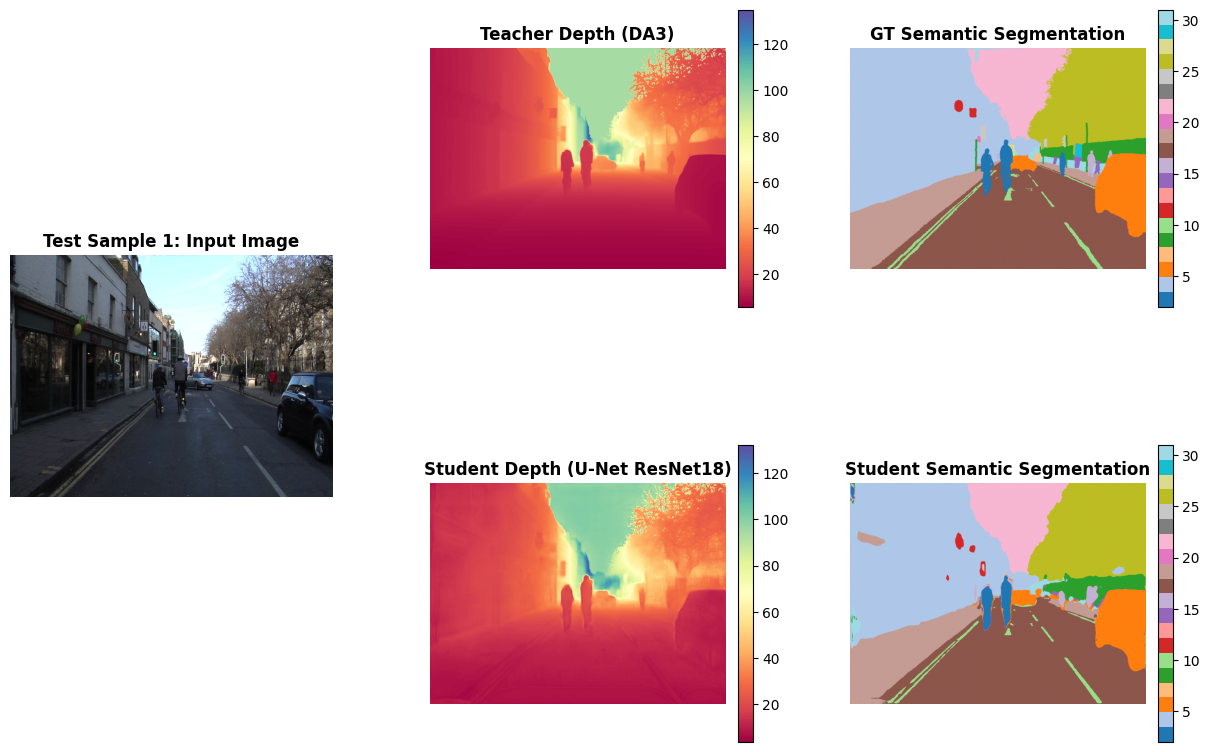

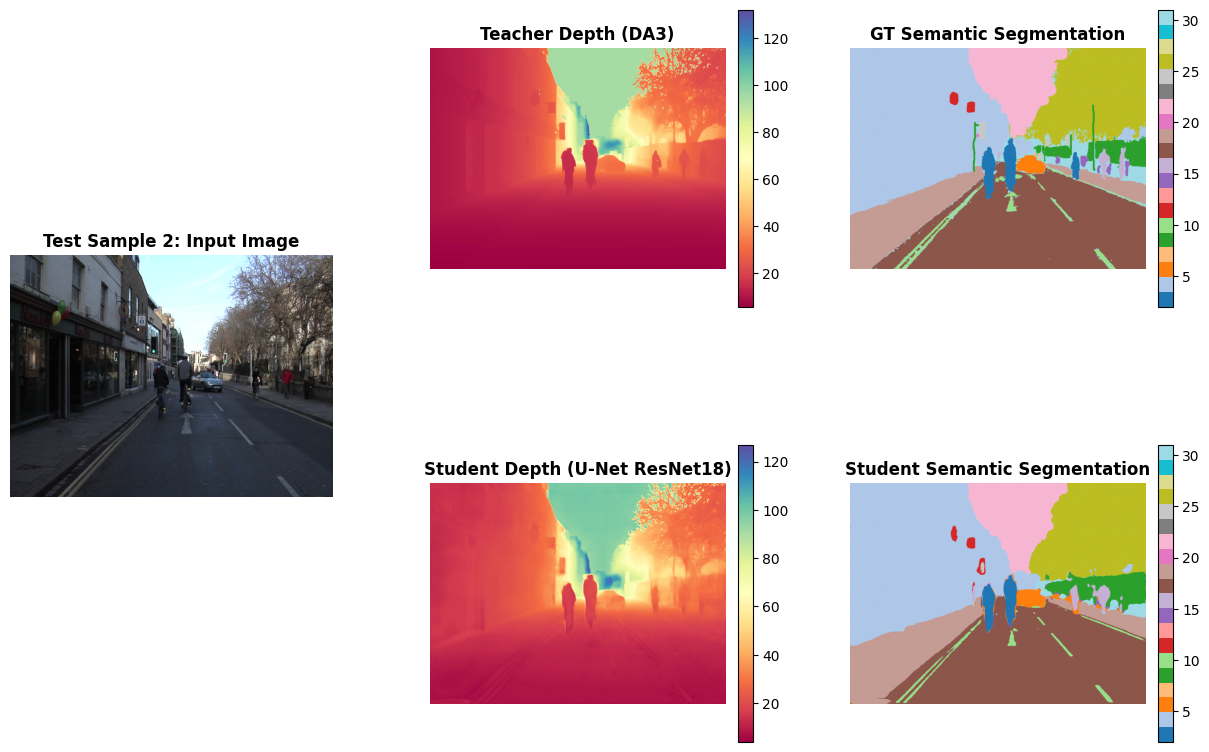

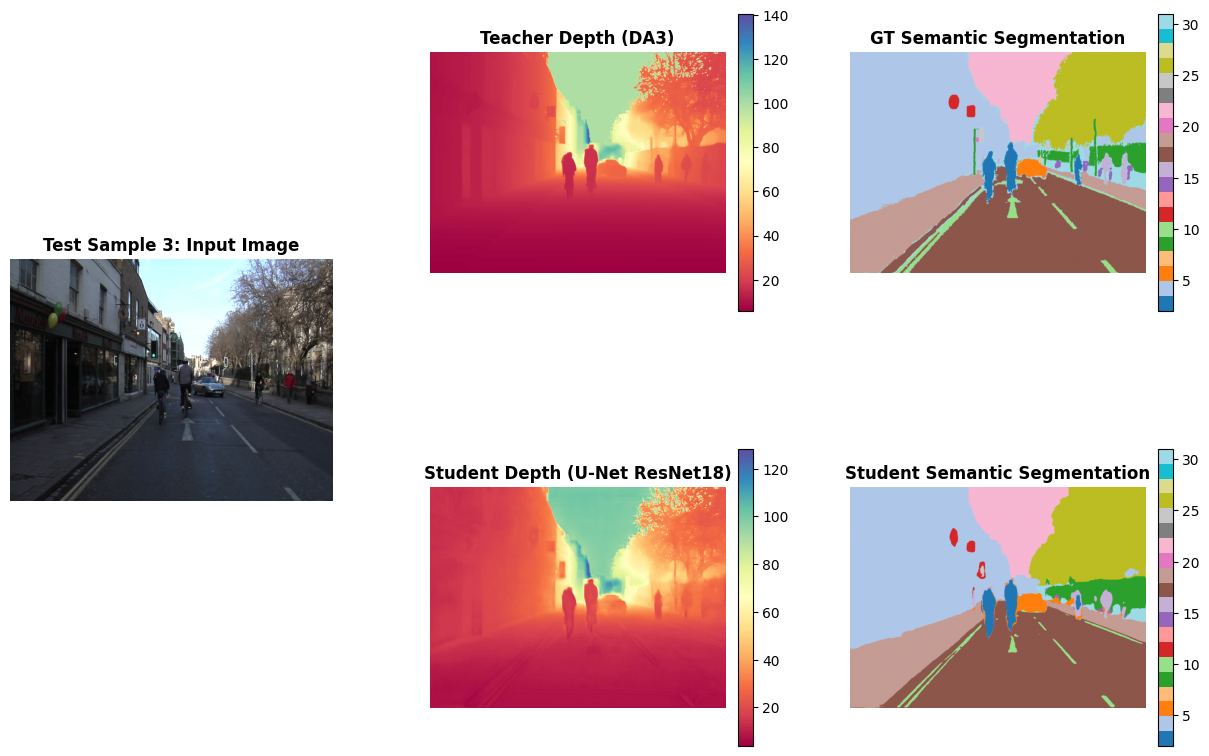

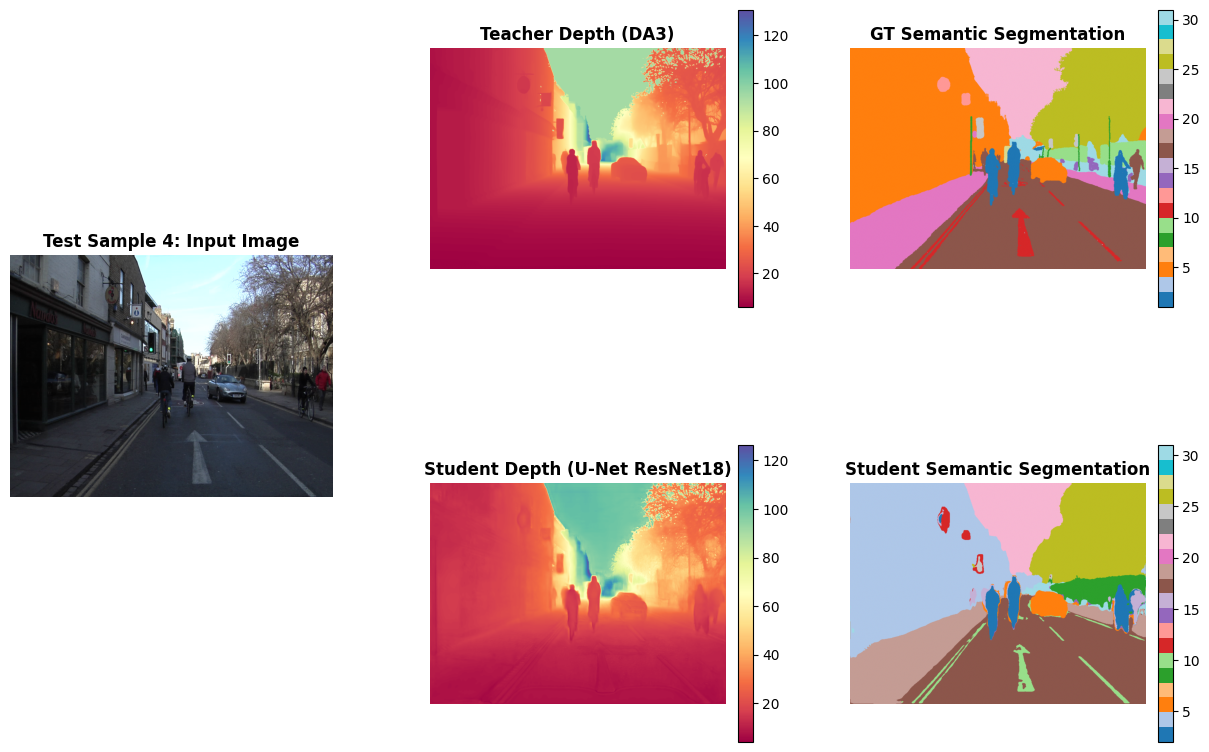

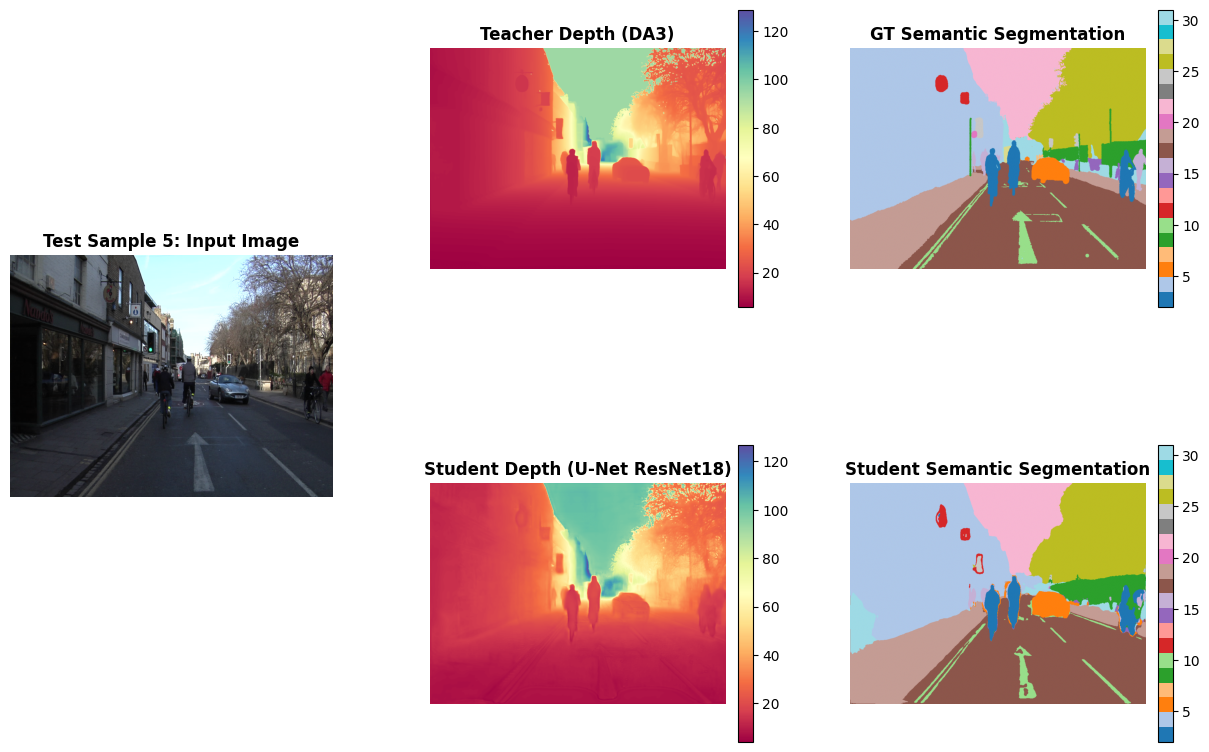

In [11]:
def visualize_predictions(model, dataset, num_samples=5, seed=42, title_prefix="Test"):
    """Visualize student predictions vs teacher depth maps and segmentation"""
    
    model = model.to(device)
    model.eval()
    
    random.seed(seed)
    offset = random.randrange(0, len(dataset) - num_samples)
    
    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            # Create figure with gridspec
            fig = plt.figure(figsize=(15, 10))
            gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
            
            image, teacher_depth, seg_mask_gt = dataset[offset + i]
            
            # Get student predictions
            student_depth_pred, student_seg_pred = model(image.unsqueeze(0).to(device))
            student_depth_pred = student_depth_pred.squeeze().cpu().numpy()
            student_seg_pred = torch.argmax(student_seg_pred, dim=1).squeeze().cpu().numpy()
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # [0, 0] and [1, 0]: Original Image (spans 2 rows)
            ax_img = fig.add_subplot(gs[:, 0])
            ax_img.imshow(img_display.permute(1, 2, 0))
            ax_img.set_title(f'{title_prefix} Sample {i+1}: Input Image', fontsize=12, fontweight='bold')
            ax_img.axis('off')
            
            # [0, 1]: Teacher Depth Map
            ax_teacher_depth = fig.add_subplot(gs[0, 1])
            im1 = ax_teacher_depth.imshow(teacher_depth.numpy(), cmap='Spectral')
            ax_teacher_depth.set_title('Teacher Depth (DA3)', fontsize=12, fontweight='bold')
            ax_teacher_depth.axis('off')
            plt.colorbar(im1, ax=ax_teacher_depth, fraction=0.046, pad=0.04)
            
            # [0, 2]: Ground Truth Semantic Segmentation
            ax_seg_gt = fig.add_subplot(gs[0, 2])
            im2 = ax_seg_gt.imshow(seg_mask_gt.numpy(), cmap='tab20')
            ax_seg_gt.set_title('GT Semantic Segmentation', fontsize=12, fontweight='bold')
            ax_seg_gt.axis('off')
            plt.colorbar(im2, ax=ax_seg_gt, fraction=0.046, pad=0.04)
            
            # [1, 1]: Student Predicted Depth Map
            ax_student_depth = fig.add_subplot(gs[1, 1])
            im3 = ax_student_depth.imshow(student_depth_pred, cmap='Spectral')
            ax_student_depth.set_title('Student Depth (U-Net ResNet18)', fontsize=12, fontweight='bold')
            ax_student_depth.axis('off')
            plt.colorbar(im3, ax=ax_student_depth, fraction=0.046, pad=0.04)
            
            # [1, 2]: Student Predicted Semantic Segmentation
            ax_student_seg = fig.add_subplot(gs[1, 2])
            im4 = ax_student_seg.imshow(student_seg_pred, cmap='tab20')
            ax_student_seg.set_title('Student Semantic Segmentation', fontsize=12, fontweight='bold')
            ax_student_seg.axis('off')
            plt.colorbar(im4, ax=ax_student_seg, fraction=0.046, pad=0.04)
            
            plt.savefig(f'{title_prefix.lower()}_predictions_sample_{i+1}.png', dpi=150, bbox_inches='tight')
            plt.show()

print("Visualizing predictions on TEST set:")
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    seg_dir=TEST_SEG_DIR,
    num_classes=32,
    is_train=False
)
visualize_predictions(lightning_module.student, test_dataset, num_samples=5, title_prefix="Test")

## 6.3 Calculate Metrics

In [12]:
def calculate_metrics(model, dataloader, split_name="Test", num_classes=32):
    """Calculate depth estimation and segmentation metrics"""
    model.to(device)
    model.eval()
    
    total_mse = 0
    total_mae = 0
    total_abs_rel = 0
    num_samples = 0
    
    # For segmentation IoU
    if num_classes is None:
        num_classes = 2  # Default to binary segmentation
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    
    with torch.no_grad():
        for images, teacher_depth, seg_mask_gt in dataloader:
            images = images.to(device)
            teacher_depth = teacher_depth.to(device)
            seg_mask_gt = seg_mask_gt.to(device)
            
            # Get predictions
            student_depth_pred, student_seg_pred = model(images)
            student_depth_pred = student_depth_pred.squeeze(1)
            
            # Depth metrics
            mse = F.mse_loss(student_depth_pred, teacher_depth)
            mae = F.l1_loss(student_depth_pred, teacher_depth)
            abs_rel = torch.mean(torch.abs(student_depth_pred - teacher_depth) / (teacher_depth + 1e-8))
            
            total_mse += mse.item() * images.size(0)
            total_mae += mae.item() * images.size(0)
            total_abs_rel += abs_rel.item() * images.size(0)
            num_samples += images.size(0)
            
            # Segmentation IoU
            # Get predicted classes (assuming student_seg_pred has shape [B, num_classes, H, W])
            seg_pred_classes = torch.argmax(student_seg_pred, dim=1)  # [B, H, W]
            
            # Ensure seg_mask_gt is the right shape (should be [B, H, W] with class indices)
            if seg_mask_gt.dim() == 4 and seg_mask_gt.size(1) > 1:
                seg_mask_gt = torch.argmax(seg_mask_gt, dim=1)
            elif seg_mask_gt.dim() == 4 and seg_mask_gt.size(1) == 1:
                seg_mask_gt = seg_mask_gt.squeeze(1)
            
            # Calculate IoU for each class
            for cls in range(num_classes):
                pred_mask = (seg_pred_classes == cls)
                gt_mask = (seg_mask_gt == cls)
                
                intersection[cls] += (pred_mask & gt_mask).sum().float()
                union[cls] += (pred_mask | gt_mask).sum().float()
    
    # Calculate IoU per class and mean IoU
    iou_per_class = intersection / (union + 1e-8)
    mean_iou = iou_per_class.mean()
    
    metrics = {
        'MSE': total_mse / num_samples,
        'MAE': total_mae / num_samples,
        'RMSE': np.sqrt(total_mse / num_samples),
        'Abs Rel': total_abs_rel / num_samples,
        'Mean IoU': mean_iou.item()
    }
    
    # Add per-class IoU
    for cls in range(num_classes):
        metrics[f'IoU Class {cls}'] = iou_per_class[cls].item()
    
    print(f"\n{split_name} Set Metrics:")
    print("=" * 40)
    print("Depth Metrics:")
    for metric_name in ['MSE', 'MAE', 'RMSE', 'Abs Rel']:
        print(f"  {metric_name:12s}: {metrics[metric_name]:.4f}")
    print("\nSegmentation Metrics:")
    print(f"  {'Mean IoU':12s}: {metrics['Mean IoU']:.4f}")
    for cls in range(num_classes):
        print(f"  {'IoU Class ' + str(cls):12s}: {metrics[f'IoU Class {cls}']:.4f}")
    print("=" * 40)
    
    return metrics

# Create data module
test_data_module = DataModule(
    train_img_dir=TRAIN_IMG_DIR,
    train_depth_dir=TRAIN_DEPTH_DIR,
    train_seg_dir=TRAIN_SEG_DIR,
    val_img_dir=VAL_IMG_DIR,
    val_depth_dir=VAL_DEPTH_DIR,
    val_seg_dir=VAL_SEG_DIR,
    test_img_dir=TEST_IMG_DIR,
    test_depth_dir=TEST_DEPTH_DIR,
    test_seg_dir=TEST_SEG_DIR,
    batch_size=best_params['batch_size'],
    num_workers=2,
    prob=None
)
test_data_module.setup(stage='test')

# Calculate metrics on TEST set
test_loader = test_data_module.test_dataloader()
test_metrics = calculate_metrics(lightning_module.student, test_loader, split_name="Test")


Test Set Metrics:
Depth Metrics:
  MSE         : 100.3994
  MAE         : 5.7901
  RMSE        : 10.0199
  Abs Rel     : 0.1630

Segmentation Metrics:
  Mean IoU    : 0.2188
  IoU Class 0 : 0.0000
  IoU Class 1 : 0.0000
  IoU Class 2 : 0.3500
  IoU Class 3 : 0.0000
  IoU Class 4 : 0.7886
  IoU Class 5 : 0.6493
  IoU Class 6 : 0.0000
  IoU Class 7 : 0.0000
  IoU Class 8 : 0.0346
  IoU Class 9 : 0.3172
  IoU Class 10: 0.5145
  IoU Class 11: 0.0000
  IoU Class 12: 0.1585
  IoU Class 13: 0.0000
  IoU Class 14: 0.0869
  IoU Class 15: 0.0144
  IoU Class 16: 0.1481
  IoU Class 17: 0.8969
  IoU Class 18: 0.0000
  IoU Class 19: 0.7249
  IoU Class 20: 0.0000
  IoU Class 21: 0.9248
  IoU Class 22: 0.0002
  IoU Class 23: 0.0000
  IoU Class 24: 0.2812
  IoU Class 25: 0.0000
  IoU Class 26: 0.7281
  IoU Class 27: 0.0000
  IoU Class 28: 0.0000
  IoU Class 29: 0.0936
  IoU Class 30: 0.0938
  IoU Class 31: 0.1948


## 6.4 Test Set Detailed Analysis
We will compute the MSE and MAE error of the selected Test samples and visualize the worst performing and best performing samples.


Per-Sample Test Results:
----------------------------------------------------------------------
Sample   0: MSE=265.7130, MAE=9.7076, Mean IoU=0.1356
Sample   1: MSE=235.4209, MAE=9.3918, Mean IoU=0.1456
Sample   2: MSE=203.5112, MAE=9.1318, Mean IoU=0.1246
Sample   3: MSE=162.0790, MAE=8.0633, Mean IoU=0.1442
Sample   4: MSE=266.7524, MAE=10.3652, Mean IoU=0.1423
Sample   5: MSE=262.8971, MAE=9.8286, Mean IoU=0.1563
Sample   6: MSE=321.7481, MAE=11.3677, Mean IoU=0.1350
Sample   7: MSE=268.0891, MAE=11.0086, Mean IoU=0.1223
Sample   8: MSE=257.6003, MAE=11.5763, Mean IoU=0.1345
Sample   9: MSE=198.8195, MAE=9.7608, Mean IoU=0.1477
Sample  10: MSE=151.7638, MAE=9.2486, Mean IoU=0.1440
Sample  11: MSE=124.3387, MAE=7.7726, Mean IoU=0.1524
Sample  12: MSE=187.2000, MAE=9.6429, Mean IoU=0.1693
Sample  13: MSE=105.8858, MAE=7.1714, Mean IoU=0.1801
Sample  14: MSE=129.2914, MAE=7.6642, Mean IoU=0.1362
Sample  15: MSE=130.1356, MAE=7.8797, Mean IoU=0.1562
Sample  16: MSE=112.7923, MAE=6.978

/tmp/ipykernel_745143/363762426.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


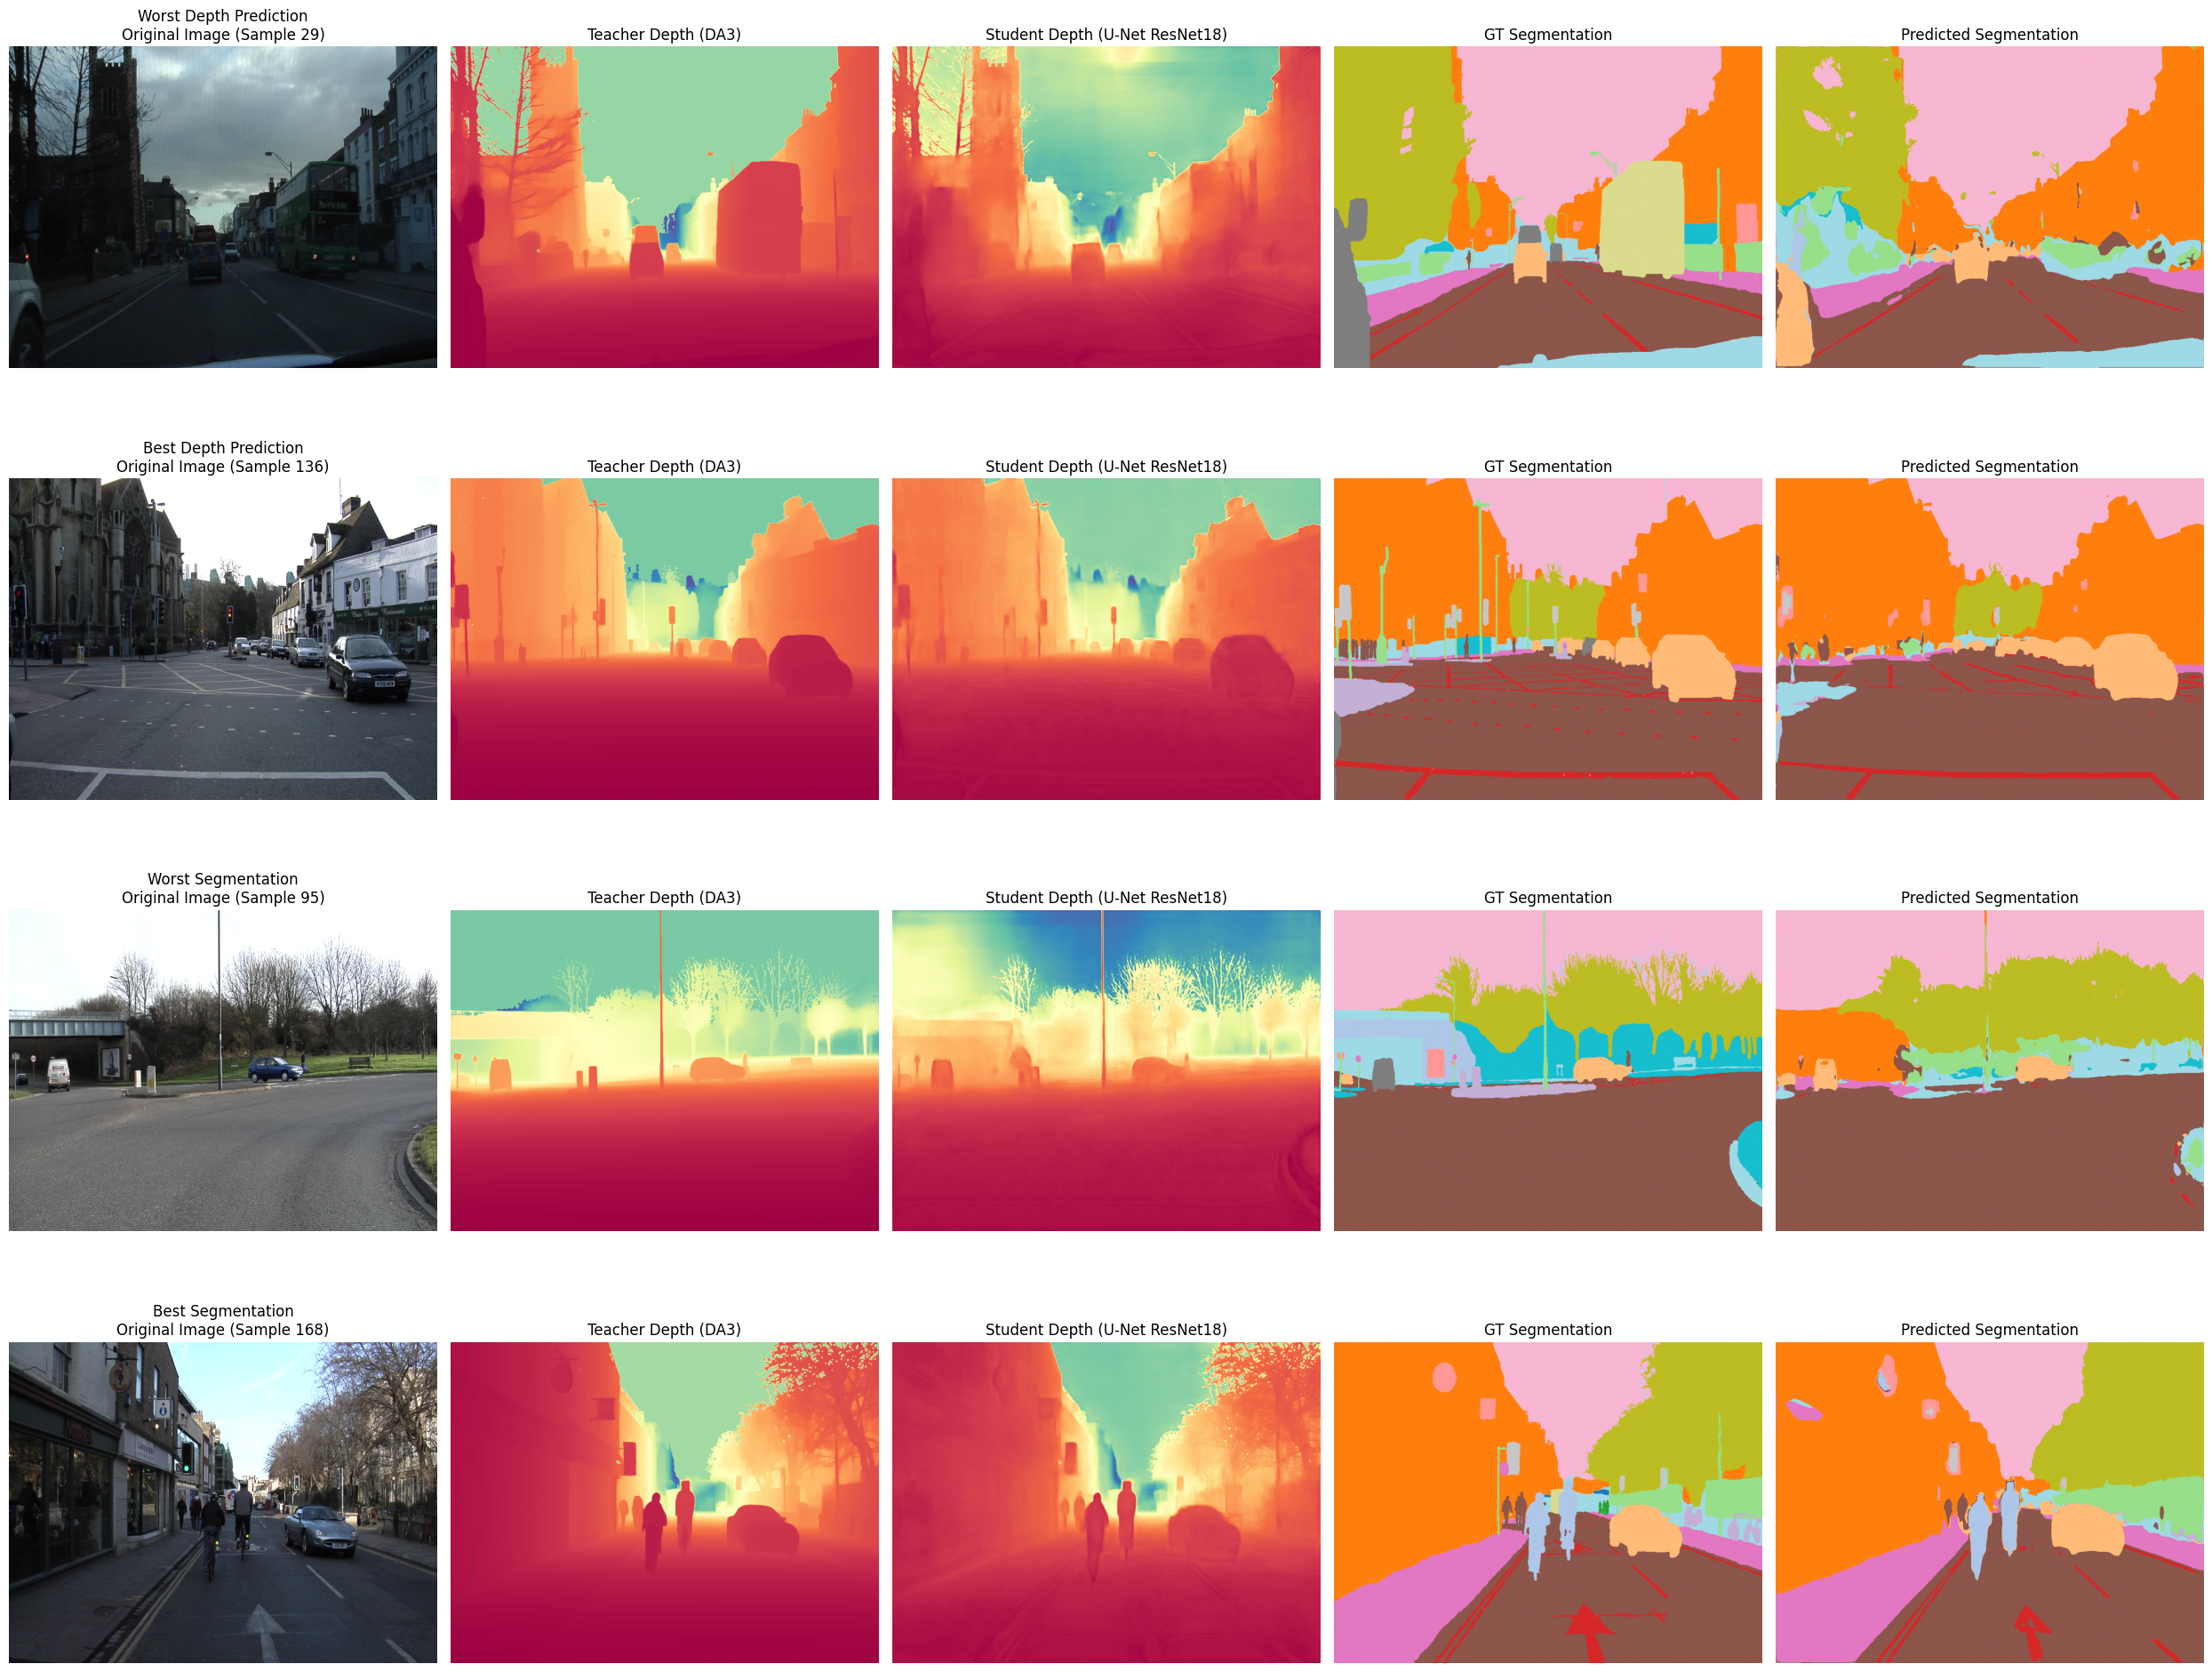

In [17]:
def visualize_predictions(model, dataset, worst_depth_idx, best_depth_idx, 
                         worst_seg_idx, best_seg_idx, num_classes=32):
    """Visualize student predictions vs teacher depth maps and segmentation masks"""
    
    model = model.to(device)
    model.eval()
    
    # Create figure with 4 rows (worst depth, best depth, worst seg, best seg) 
    # and 5 columns (image, teacher depth, student depth, GT seg, pred seg)
    fig, axes = plt.subplots(4, 5, figsize=(25, 20))
    
    with torch.no_grad():
        samples_to_plot = [
            (worst_depth_idx, 0, 'Worst Depth Prediction', 'worst_depth'),
            (best_depth_idx, 1, 'Best Depth Prediction', 'best_depth'),
            (worst_seg_idx, 2, 'Worst Segmentation', 'worst_seg'),
            (best_seg_idx, 3, 'Best Segmentation', 'best_seg')
        ]
        
        for sample_idx, row, title_prefix, save_name in samples_to_plot:
            image, teacher_depth, seg_mask_gt = dataset[sample_idx]
            
            # Get student prediction
            student_depth_pred, student_seg_pred = model(image.unsqueeze(0).to(device))
            student_depth = student_depth_pred.squeeze().cpu().numpy()
            student_seg = torch.argmax(student_seg_pred, dim=1).squeeze().cpu().numpy()
            
            # Handle seg_mask_gt shape
            if seg_mask_gt.dim() == 3 and seg_mask_gt.size(0) > 1:
                seg_mask_gt = torch.argmax(seg_mask_gt, dim=0)
            elif seg_mask_gt.dim() == 3 and seg_mask_gt.size(0) == 1:
                seg_mask_gt = seg_mask_gt.squeeze(0)
            
            # Denormalize image for visualization
            img_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_display = img_display * std + mean
            img_display = torch.clamp(img_display, 0, 1)
            
            # Plot original image
            axes[row, 0].imshow(img_display.permute(1, 2, 0))
            axes[row, 0].set_title(f'{title_prefix}\nOriginal Image (Sample {sample_idx})')
            axes[row, 0].axis('off')
            
            # Plot teacher depth
            axes[row, 1].imshow(teacher_depth.numpy(), cmap='Spectral')
            axes[row, 1].set_title('Teacher Depth (DA3)')
            axes[row, 1].axis('off')
            
            # Plot student depth
            axes[row, 2].imshow(student_depth, cmap='Spectral')
            axes[row, 2].set_title('Student Depth (U-Net ResNet18)')
            axes[row, 2].axis('off')
            
            # Use a colormap for segmentation
            cmap = plt.cm.get_cmap('tab20', num_classes)
            
            # Plot GT segmentation
            seg_gt_colored = np.zeros((*seg_mask_gt.shape, 3))
            for cls in range(num_classes):
                mask_gt = (seg_mask_gt.numpy() == cls)
                color = cmap(cls)[:3]
                for c in range(3):
                    seg_gt_colored[:, :, c][mask_gt] = color[c]
            
            axes[row, 3].imshow(seg_gt_colored)
            axes[row, 3].set_title('GT Segmentation')
            axes[row, 3].axis('off')
            
            # Plot predicted segmentation
            seg_pred_colored = np.zeros((*student_seg.shape, 3))
            for cls in range(num_classes):
                mask_pred = (student_seg == cls)
                color = cmap(cls)[:3]
                for c in range(3):
                    seg_pred_colored[:, :, c][mask_pred] = color[c]
            
            axes[row, 4].imshow(seg_pred_colored)
            axes[row, 4].set_title('Predicted Segmentation')
            axes[row, 4].axis('off')
            
            # Save individual plot in 2x3 grid
            save_individual_plot(
                img_display, teacher_depth, student_depth, 
                seg_gt_colored, seg_pred_colored, 
                sample_idx, title_prefix, save_name
            )
    
    plt.tight_layout()
    plt.savefig(f'complete_predictions_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()


def save_individual_plot(img_display, teacher_depth, student_depth, 
                        seg_gt_colored, seg_pred_colored, 
                        sample_idx, title_prefix, save_name):
    """Save individual sample in 2x3 grid with original image spanning 2 rows"""
    
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)
    
    # Original image spans rows 0 and 1, column 0
    ax_img = fig.add_subplot(gs[:, 0])
    ax_img.imshow(img_display.permute(1, 2, 0))
    ax_img.set_title(f'{title_prefix}\nOriginal Image (Sample {sample_idx})', fontsize=12)
    ax_img.axis('off')
    
    # Teacher depth at [0, 1]
    ax_teacher = fig.add_subplot(gs[0, 1])
    ax_teacher.imshow(teacher_depth.numpy(), cmap='Spectral')
    ax_teacher.set_title('Teacher Depth (DA3)', fontsize=12)
    ax_teacher.axis('off')
    
    # Student depth at [0, 2]
    ax_student = fig.add_subplot(gs[0, 2])
    ax_student.imshow(student_depth, cmap='Spectral')
    ax_student.set_title('Student Depth (U-Net ResNet18)', fontsize=12)
    ax_student.axis('off')
    
    # GT segmentation at [1, 1]
    ax_gt_seg = fig.add_subplot(gs[1, 1])
    ax_gt_seg.imshow(seg_gt_colored)
    ax_gt_seg.set_title('GT Segmentation', fontsize=12)
    ax_gt_seg.axis('off')
    
    # Predicted segmentation at [1, 2]
    ax_pred_seg = fig.add_subplot(gs[1, 2])
    ax_pred_seg.imshow(seg_pred_colored)
    ax_pred_seg.set_title('Predicted Segmentation', fontsize=12)
    ax_pred_seg.axis('off')
    
    plt.savefig(f'{save_name}_sample_{sample_idx}.png', dpi=150, bbox_inches='tight')
    plt.close(fig)


# Run detailed analysis
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    seg_dir=TEST_SEG_DIR,
    num_classes=32
)

worst_depth_idx, best_depth_idx, worst_seg_idx, best_seg_idx = detailed_test_analysis(
    lightning_module.student, 
    test_dataset, 
    num_samples=len(test_dataset),
    num_classes=32
)

print(f"\nWorst depth prediction at sample #{worst_depth_idx}")
print(f"Best depth prediction at sample #{best_depth_idx}")
print(f"Worst segmentation at sample #{worst_seg_idx}")
print(f"Best segmentation at sample #{best_seg_idx}")
print()

visualize_predictions(
    lightning_module.student, 
    test_dataset, 
    worst_depth_idx, 
    best_depth_idx,
    worst_seg_idx,
    best_seg_idx,
    num_classes=32
)

# 7. Teacher vs Student Comparison
For the last part of this notebook, we will perform a little benchmark for both Teacher and Student models so we can compare them in terms of number of parameters (model size) and inference time.

In [36]:
from time import time
from tqdm import tqdm
from depth_anything_3.api import DepthAnything3

## 7.1 Load Teacher Model

In [30]:
# Load model from Hugging Face Hub
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher = DepthAnything3.from_pretrained("depth-anything/DA3NESTED-GIANT-LARGE")
teacher = teacher.to(device=device)
teacher.eval()
print('Model loaded!')

[INFO ] using SwiGLU layer as FFN
[INFO ] using MLP layer as FFN
Model loaded!


## 7.2 Model Size Comparison

In [31]:
teacher_num_params = sum(p.numel() for p in teacher.parameters())
student_num_params = sum(p.numel() for p in student.parameters())

In [32]:
print(teacher_num_params, student_num_params)

1689845519 14328625


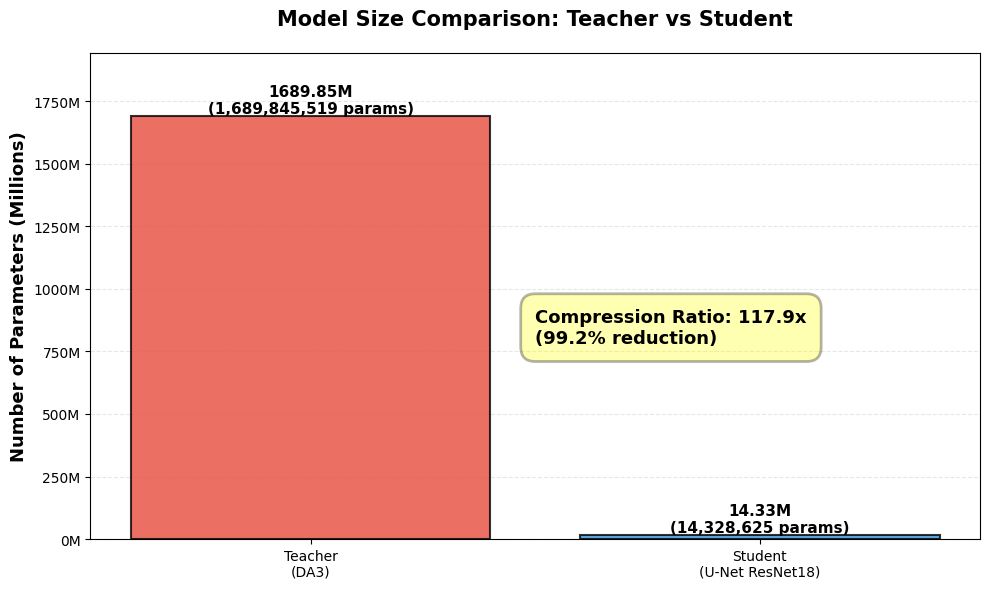


Model Size Summary:
Teacher (DA3):              1689.85M parameters
Student (U-Net ResNet18):      14.33M parameters
Compression Ratio:             117.9x
Parameter Reduction:            99.2%


In [33]:
# Convert to millions for better readability
teacher_params_M = teacher_num_params / 1e6
student_params_M = student_num_params / 1e6

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Data
models = ['Teacher\n(DA3)', 'Student\n(U-Net ResNet18)']
params = [teacher_params_M, student_params_M]
colors = ['#E74C3C', '#3498DB']  # Red for teacher, blue for student

# Create bar chart
bars = ax.bar(models, params, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on top of bars
for bar, param in zip(bars, params):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{param:.2f}M\n({param*1e6:,.0f} params)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Calculate compression ratio
compression_ratio = teacher_params_M / student_params_M

# Add compression ratio annotation
ax.text(0.5, max(params) * 0.5, 
        f'Compression Ratio: {compression_ratio:.1f}x\n({(1-student_params_M/teacher_params_M)*100:.1f}% reduction)',
        ha='left', va='center', fontsize=13, 
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.3, edgecolor='black', linewidth=2),
        fontweight='bold')

# Styling
ax.set_ylabel('Number of Parameters (Millions)', fontsize=13, fontweight='bold')
ax.set_title('Model Size Comparison: Teacher vs Student', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, max(params) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}M'))

plt.tight_layout()
plt.savefig('model_size_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nModel Size Summary:")
print("=" * 50)
print(f"Teacher (DA3):           {teacher_params_M:>10.2f}M parameters")
print(f"Student (U-Net ResNet18): {student_params_M:>10.2f}M parameters")
print(f"Compression Ratio:        {compression_ratio:>10.1f}x")
print(f"Parameter Reduction:      {(1-student_params_M/teacher_params_M)*100:>10.1f}%")
print("=" * 50)

## 7.3 Inference Time

In [34]:
test_dataset = DepthDistillationDataset(
    img_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    seg_dir=TEST_SEG_DIR,
    num_classes=32
)

### 7.3.1 Teacher

In [43]:
teacher_inference_times = []
for idx in tqdm(range(len(test_dataset))):
    image, _, _ = test_dataset[idx]
    
    # Denormalize the image (assuming ImageNet normalization)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image * std + mean
    image = torch.clamp(image, 0, 1)
    
    # Convert to numpy array in HWC format and scale to 0-255 uint8
    image = image.cpu().numpy()
    image = np.transpose(image, (1, 2, 0))  # CHW -> HWC
    image = (image * 255).astype(np.uint8)  # Convert to uint8
    
    start = time()
    _ = teacher.inference(
        [image],
        process_res=960
    )
    end = time()
    elapsed_time = end - start
    teacher_inference_times.append(elapsed_time)

  0%|                                                   | 0/232 [00:00<?, ?it/s]

[INFO ] Processed Images Done taking 0.48378539085388184 seconds. Shape:  torch.Size([1, 3, 714, 966])


  0%|▏                                          | 1/232 [00:09<35:16,  9.16s/it]

[INFO ] Model Forward Pass Done. Time: 7.698428392410278 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00229644775390625 seconds
[INFO ] Processed Images Done taking 0.031423091888427734 seconds. Shape:  torch.Size([1, 3, 714, 966])


  1%|▎                                          | 2/232 [00:11<18:49,  4.91s/it]

[INFO ] Model Forward Pass Done. Time: 1.8282372951507568 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011360645294189453 seconds
[INFO ] Processed Images Done taking 0.03953146934509277 seconds. Shape:  torch.Size([1, 3, 714, 966])


  1%|▌                                          | 3/232 [00:11<10:57,  2.87s/it]

[INFO ] Model Forward Pass Done. Time: 0.3452615737915039 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001058340072631836 seconds
[INFO ] Processed Images Done taking 0.03908538818359375 seconds. Shape:  torch.Size([1, 3, 714, 966])


  2%|▋                                          | 4/232 [00:12<07:22,  1.94s/it]

[INFO ] Model Forward Pass Done. Time: 0.3448522090911865 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012116432189941406 seconds
[INFO ] Processed Images Done taking 0.033866167068481445 seconds. Shape:  torch.Size([1, 3, 714, 966])


  2%|▉                                          | 5/232 [00:12<05:18,  1.40s/it]

[INFO ] Model Forward Pass Done. Time: 0.34748363494873047 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001035451889038086 seconds
[INFO ] Processed Images Done taking 0.031041860580444336 seconds. Shape:  torch.Size([1, 3, 714, 966])


  3%|█                                          | 6/232 [00:12<04:03,  1.08s/it]

[INFO ] Model Forward Pass Done. Time: 0.34529876708984375 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010480880737304688 seconds
[INFO ] Processed Images Done taking 0.03314685821533203 seconds. Shape:  torch.Size([1, 3, 714, 966])


  3%|█▎                                         | 7/232 [00:13<03:14,  1.15it/s]

[INFO ] Model Forward Pass Done. Time: 0.34511470794677734 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010869503021240234 seconds
[INFO ] Processed Images Done taking 0.03050541877746582 seconds. Shape:  torch.Size([1, 3, 714, 966])


  3%|█▍                                         | 8/232 [00:13<02:42,  1.37it/s]

[INFO ] Model Forward Pass Done. Time: 0.34685206413269043 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009760856628417969 seconds
[INFO ] Processed Images Done taking 0.030589580535888672 seconds. Shape:  torch.Size([1, 3, 714, 966])


  4%|█▋                                         | 9/232 [00:14<02:21,  1.58it/s]

[INFO ] Model Forward Pass Done. Time: 0.345855712890625 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010952949523925781 seconds
[INFO ] Processed Images Done taking 0.03981733322143555 seconds. Shape:  torch.Size([1, 3, 714, 966])


  4%|█▊                                        | 10/232 [00:14<02:07,  1.74it/s]

[INFO ] Model Forward Pass Done. Time: 0.3469817638397217 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012269020080566406 seconds
[INFO ] Processed Images Done taking 0.03193545341491699 seconds. Shape:  torch.Size([1, 3, 714, 966])


  5%|█▉                                        | 11/232 [00:15<01:58,  1.87it/s]

[INFO ] Model Forward Pass Done. Time: 0.3460254669189453 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010170936584472656 seconds
[INFO ] Processed Images Done taking 0.03964519500732422 seconds. Shape:  torch.Size([1, 3, 714, 966])


  5%|██▏                                       | 12/232 [00:15<01:51,  1.97it/s]

[INFO ] Model Forward Pass Done. Time: 0.3455798625946045 seconds
[INFO ] Conversion to Prediction Done. Time: 0.004712104797363281 seconds
[INFO ] Processed Images Done taking 0.03368353843688965 seconds. Shape:  torch.Size([1, 3, 714, 966])


  6%|██▎                                       | 13/232 [00:16<01:49,  2.01it/s]

[INFO ] Model Forward Pass Done. Time: 0.3461167812347412 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009732246398925781 seconds
[INFO ] Processed Images Done taking 0.03331160545349121 seconds. Shape:  torch.Size([1, 3, 714, 966])


  6%|██▌                                       | 14/232 [00:16<01:44,  2.09it/s]

[INFO ] Model Forward Pass Done. Time: 0.3455038070678711 seconds
[INFO ] Conversion to Prediction Done. Time: 0.000982522964477539 seconds
[INFO ] Processed Images Done taking 0.05196690559387207 seconds. Shape:  torch.Size([1, 3, 714, 966])


  6%|██▋                                       | 15/232 [00:16<01:41,  2.13it/s]

[INFO ] Model Forward Pass Done. Time: 0.34612441062927246 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001009225845336914 seconds
[INFO ] Processed Images Done taking 0.03782773017883301 seconds. Shape:  torch.Size([1, 3, 714, 966])


  7%|██▉                                       | 16/232 [00:17<01:39,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.34571051597595215 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012204647064208984 seconds
[INFO ] Processed Images Done taking 0.03254246711730957 seconds. Shape:  torch.Size([1, 3, 714, 966])


  7%|███                                       | 17/232 [00:17<01:38,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.34627461433410645 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012745857238769531 seconds
[INFO ] Processed Images Done taking 0.0350339412689209 seconds. Shape:  torch.Size([1, 3, 714, 966])


  8%|███▎                                      | 18/232 [00:18<01:37,  2.19it/s]

[INFO ] Model Forward Pass Done. Time: 0.3470597267150879 seconds
[INFO ] Conversion to Prediction Done. Time: 0.004489898681640625 seconds
[INFO ] Processed Images Done taking 0.03979015350341797 seconds. Shape:  torch.Size([1, 3, 714, 966])


  8%|███▍                                      | 19/232 [00:18<01:36,  2.20it/s]

[INFO ] Model Forward Pass Done. Time: 0.34825658798217773 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012142658233642578 seconds
[INFO ] Processed Images Done taking 0.034924983978271484 seconds. Shape:  torch.Size([1, 3, 714, 966])


  9%|███▌                                      | 20/232 [00:19<01:35,  2.22it/s]

[INFO ] Model Forward Pass Done. Time: 0.3472023010253906 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010323524475097656 seconds
[INFO ] Processed Images Done taking 0.03343009948730469 seconds. Shape:  torch.Size([1, 3, 714, 966])


  9%|███▊                                      | 21/232 [00:19<01:34,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.3467981815338135 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011179447174072266 seconds
[INFO ] Processed Images Done taking 0.0351262092590332 seconds. Shape:  torch.Size([1, 3, 714, 966])


  9%|███▉                                      | 22/232 [00:20<01:33,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3465769290924072 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001409292221069336 seconds
[INFO ] Processed Images Done taking 0.031116485595703125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 10%|████▏                                     | 23/232 [00:20<01:32,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.34584546089172363 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010395050048828125 seconds
[INFO ] Processed Images Done taking 0.0324559211730957 seconds. Shape:  torch.Size([1, 3, 714, 966])


 10%|████▎                                     | 24/232 [00:20<01:33,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3484063148498535 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015723705291748047 seconds
[INFO ] Processed Images Done taking 0.040841102600097656 seconds. Shape:  torch.Size([1, 3, 714, 966])


 11%|████▌                                     | 25/232 [00:21<01:33,  2.20it/s]

[INFO ] Model Forward Pass Done. Time: 0.34691858291625977 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001516103744506836 seconds
[INFO ] Processed Images Done taking 0.040946245193481445 seconds. Shape:  torch.Size([1, 3, 714, 966])


 11%|████▋                                     | 26/232 [00:21<01:33,  2.19it/s]

[INFO ] Model Forward Pass Done. Time: 0.3482089042663574 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011410713195800781 seconds
[INFO ] Processed Images Done taking 0.03123950958251953 seconds. Shape:  torch.Size([1, 3, 714, 966])


 12%|████▉                                     | 27/232 [00:22<01:31,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.3464198112487793 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011289119720458984 seconds
[INFO ] Processed Images Done taking 0.031231403350830078 seconds. Shape:  torch.Size([1, 3, 714, 966])


 12%|█████                                     | 28/232 [00:22<01:30,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.34641313552856445 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010848045349121094 seconds
[INFO ] Processed Images Done taking 0.029806852340698242 seconds. Shape:  torch.Size([1, 3, 714, 966])


 12%|█████▎                                    | 29/232 [00:23<01:29,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34572458267211914 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0007936954498291016 seconds
[INFO ] Processed Images Done taking 0.03051161766052246 seconds. Shape:  torch.Size([1, 3, 714, 966])


 13%|█████▍                                    | 30/232 [00:23<01:28,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3479142189025879 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010144710540771484 seconds
[INFO ] Processed Images Done taking 0.030142784118652344 seconds. Shape:  torch.Size([1, 3, 714, 966])


 13%|█████▌                                    | 31/232 [00:24<01:28,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34798574447631836 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0014052391052246094 seconds
[INFO ] Processed Images Done taking 0.03025078773498535 seconds. Shape:  torch.Size([1, 3, 714, 966])


 14%|█████▊                                    | 32/232 [00:24<01:27,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3478214740753174 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010156631469726562 seconds
[INFO ] Processed Images Done taking 0.03696084022521973 seconds. Shape:  torch.Size([1, 3, 714, 966])


 14%|█████▉                                    | 33/232 [00:24<01:27,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34874510765075684 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001033782958984375 seconds
[INFO ] Processed Images Done taking 0.028200149536132812 seconds. Shape:  torch.Size([1, 3, 714, 966])


 15%|██████▏                                   | 34/232 [00:25<01:26,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483150005340576 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011417865753173828 seconds
[INFO ] Processed Images Done taking 0.02785468101501465 seconds. Shape:  torch.Size([1, 3, 714, 966])


 15%|██████▎                                   | 35/232 [00:25<01:27,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.350311279296875 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010266304016113281 seconds
[INFO ] Processed Images Done taking 0.030295372009277344 seconds. Shape:  torch.Size([1, 3, 714, 966])


 16%|██████▌                                   | 36/232 [00:26<01:26,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496127128601074 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001130819320678711 seconds
[INFO ] Processed Images Done taking 0.029189348220825195 seconds. Shape:  torch.Size([1, 3, 714, 966])


 16%|██████▋                                   | 37/232 [00:26<01:25,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.35054492950439453 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012385845184326172 seconds
[INFO ] Processed Images Done taking 0.027930736541748047 seconds. Shape:  torch.Size([1, 3, 714, 966])


 16%|██████▉                                   | 38/232 [00:27<01:25,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.349520206451416 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011553764343261719 seconds
[INFO ] Processed Images Done taking 0.03284001350402832 seconds. Shape:  torch.Size([1, 3, 714, 966])


 17%|███████                                   | 39/232 [00:27<01:27,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.3491549491882324 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011487007141113281 seconds
[INFO ] Processed Images Done taking 0.027410268783569336 seconds. Shape:  torch.Size([1, 3, 714, 966])


 17%|███████▏                                  | 40/232 [00:28<01:25,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.34896039962768555 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011487007141113281 seconds
[INFO ] Processed Images Done taking 0.0681619644165039 seconds. Shape:  torch.Size([1, 3, 714, 966])


 18%|███████▍                                  | 41/232 [00:28<01:35,  2.01it/s]

[INFO ] Model Forward Pass Done. Time: 0.3593409061431885 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011775493621826172 seconds
[INFO ] Processed Images Done taking 0.023746013641357422 seconds. Shape:  torch.Size([1, 3, 714, 966])


 18%|███████▌                                  | 42/232 [00:29<01:31,  2.08it/s]

[INFO ] Model Forward Pass Done. Time: 0.34938526153564453 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009932518005371094 seconds
[INFO ] Processed Images Done taking 0.03343844413757324 seconds. Shape:  torch.Size([1, 3, 714, 966])


 19%|███████▊                                  | 43/232 [00:29<01:29,  2.11it/s]

[INFO ] Model Forward Pass Done. Time: 0.3489959239959717 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0017631053924560547 seconds
[INFO ] Processed Images Done taking 0.02469778060913086 seconds. Shape:  torch.Size([1, 3, 714, 966])


 19%|███████▉                                  | 44/232 [00:29<01:26,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.3491182327270508 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010235309600830078 seconds
[INFO ] Processed Images Done taking 0.027458906173706055 seconds. Shape:  torch.Size([1, 3, 714, 966])


 19%|████████▏                                 | 45/232 [00:30<01:24,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.3491835594177246 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001191854476928711 seconds
[INFO ] Processed Images Done taking 0.034562110900878906 seconds. Shape:  torch.Size([1, 3, 714, 966])


 20%|████████▎                                 | 46/232 [00:30<01:24,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.3487837314605713 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009627342224121094 seconds
[INFO ] Processed Images Done taking 0.02349710464477539 seconds. Shape:  torch.Size([1, 3, 714, 966])


 20%|████████▌                                 | 47/232 [00:31<01:22,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.34850478172302246 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011718273162841797 seconds
[INFO ] Processed Images Done taking 0.03682446479797363 seconds. Shape:  torch.Size([1, 3, 714, 966])


 21%|████████▋                                 | 48/232 [00:31<01:22,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.3492603302001953 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008616447448730469 seconds
[INFO ] Processed Images Done taking 0.027713537216186523 seconds. Shape:  torch.Size([1, 3, 714, 966])


 21%|████████▊                                 | 49/232 [00:32<01:21,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483242988586426 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0014090538024902344 seconds
[INFO ] Processed Images Done taking 0.03069448471069336 seconds. Shape:  torch.Size([1, 3, 714, 966])


 22%|█████████                                 | 50/232 [00:32<01:23,  2.18it/s]

[INFO ] Model Forward Pass Done. Time: 0.3490281105041504 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0014019012451171875 seconds
[INFO ] Processed Images Done taking 0.023821592330932617 seconds. Shape:  torch.Size([1, 3, 714, 966])


 22%|█████████▏                                | 51/232 [00:33<01:21,  2.22it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499410152435303 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011508464813232422 seconds
[INFO ] Processed Images Done taking 0.027942657470703125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 22%|█████████▍                                | 52/232 [00:33<01:20,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.3492281436920166 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009829998016357422 seconds
[INFO ] Processed Images Done taking 0.022783756256103516 seconds. Shape:  torch.Size([1, 3, 714, 966])


 23%|█████████▌                                | 53/232 [00:33<01:18,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483738899230957 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010058879852294922 seconds
[INFO ] Processed Images Done taking 0.031287193298339844 seconds. Shape:  torch.Size([1, 3, 714, 966])


 23%|█████████▊                                | 54/232 [00:34<01:18,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3492610454559326 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0022335052490234375 seconds
[INFO ] Processed Images Done taking 0.033383846282958984 seconds. Shape:  torch.Size([1, 3, 714, 966])


 24%|█████████▉                                | 55/232 [00:34<01:18,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.3484008312225342 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011444091796875 seconds
[INFO ] Processed Images Done taking 0.03118419647216797 seconds. Shape:  torch.Size([1, 3, 714, 966])


 24%|██████████▏                               | 56/232 [00:35<01:17,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.35033440589904785 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009894371032714844 seconds
[INFO ] Processed Images Done taking 0.026727914810180664 seconds. Shape:  torch.Size([1, 3, 714, 966])


 25%|██████████▎                               | 57/232 [00:35<01:16,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34779858589172363 seconds
[INFO ] Conversion to Prediction Done. Time: 0.000980377197265625 seconds
[INFO ] Processed Images Done taking 0.026590824127197266 seconds. Shape:  torch.Size([1, 3, 714, 966])


 25%|██████████▌                               | 58/232 [00:36<01:15,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499898910522461 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010190010070800781 seconds
[INFO ] Processed Images Done taking 0.024328947067260742 seconds. Shape:  torch.Size([1, 3, 714, 966])


 25%|██████████▋                               | 59/232 [00:36<01:14,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34984493255615234 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009789466857910156 seconds
[INFO ] Processed Images Done taking 0.021963834762573242 seconds. Shape:  torch.Size([1, 3, 714, 966])


 26%|██████████▊                               | 60/232 [00:37<01:13,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3497154712677002 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0007901191711425781 seconds
[INFO ] Processed Images Done taking 0.03071451187133789 seconds. Shape:  torch.Size([1, 3, 714, 966])


 26%|███████████                               | 61/232 [00:37<01:13,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499917984008789 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008428096771240234 seconds
[INFO ] Processed Images Done taking 0.02423238754272461 seconds. Shape:  torch.Size([1, 3, 714, 966])


 27%|███████████▏                              | 62/232 [00:37<01:13,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.35425806045532227 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009274482727050781 seconds
[INFO ] Processed Images Done taking 0.06351971626281738 seconds. Shape:  torch.Size([1, 3, 714, 966])


 27%|███████████▍                              | 63/232 [00:38<01:20,  2.10it/s]

[INFO ] Model Forward Pass Done. Time: 0.3515143394470215 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010712146759033203 seconds
[INFO ] Processed Images Done taking 0.02186441421508789 seconds. Shape:  torch.Size([1, 3, 714, 966])


 28%|███████████▌                              | 64/232 [00:38<01:17,  2.16it/s]

[INFO ] Model Forward Pass Done. Time: 0.3486461639404297 seconds
[INFO ] Conversion to Prediction Done. Time: 0.000995635986328125 seconds
[INFO ] Processed Images Done taking 0.022403478622436523 seconds. Shape:  torch.Size([1, 3, 714, 966])


 28%|███████████▊                              | 65/232 [00:39<01:15,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.34925031661987305 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0022211074829101562 seconds
[INFO ] Processed Images Done taking 0.02337813377380371 seconds. Shape:  torch.Size([1, 3, 714, 966])


 28%|███████████▉                              | 66/232 [00:39<01:14,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.34923458099365234 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012087821960449219 seconds
[INFO ] Processed Images Done taking 0.023034095764160156 seconds. Shape:  torch.Size([1, 3, 714, 966])


 29%|████████████▏                             | 67/232 [00:40<01:12,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3490276336669922 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015339851379394531 seconds
[INFO ] Processed Images Done taking 0.022597789764404297 seconds. Shape:  torch.Size([1, 3, 714, 966])


 29%|████████████▎                             | 68/232 [00:40<01:11,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34992551803588867 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011458396911621094 seconds
[INFO ] Processed Images Done taking 0.02472829818725586 seconds. Shape:  torch.Size([1, 3, 714, 966])


 30%|████████████▍                             | 69/232 [00:41<01:12,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494565486907959 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010347366333007812 seconds
[INFO ] Processed Images Done taking 0.02356243133544922 seconds. Shape:  torch.Size([1, 3, 714, 966])


 30%|████████████▋                             | 70/232 [00:41<01:11,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494277000427246 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001007080078125 seconds
[INFO ] Processed Images Done taking 0.025472402572631836 seconds. Shape:  torch.Size([1, 3, 714, 966])


 31%|████████████▊                             | 71/232 [00:41<01:10,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3493368625640869 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011277198791503906 seconds
[INFO ] Processed Images Done taking 0.023188352584838867 seconds. Shape:  torch.Size([1, 3, 714, 966])


 31%|█████████████                             | 72/232 [00:42<01:10,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34992051124572754 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0022411346435546875 seconds
[INFO ] Processed Images Done taking 0.028873682022094727 seconds. Shape:  torch.Size([1, 3, 714, 966])


 31%|█████████████▏                            | 73/232 [00:42<01:10,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34964966773986816 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010602474212646484 seconds
[INFO ] Processed Images Done taking 0.02344655990600586 seconds. Shape:  torch.Size([1, 3, 714, 966])


 32%|█████████████▍                            | 74/232 [00:43<01:08,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34978294372558594 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011963844299316406 seconds
[INFO ] Processed Images Done taking 0.023032188415527344 seconds. Shape:  torch.Size([1, 3, 714, 966])


 32%|█████████████▌                            | 75/232 [00:43<01:08,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3502838611602783 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00115203857421875 seconds
[INFO ] Processed Images Done taking 0.023960351943969727 seconds. Shape:  torch.Size([1, 3, 714, 966])


 33%|█████████████▊                            | 76/232 [00:44<01:07,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.349149227142334 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009872913360595703 seconds
[INFO ] Processed Images Done taking 0.022054672241210938 seconds. Shape:  torch.Size([1, 3, 714, 966])


 33%|█████████████▉                            | 77/232 [00:44<01:06,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494231700897217 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010695457458496094 seconds
[INFO ] Processed Images Done taking 0.026509523391723633 seconds. Shape:  torch.Size([1, 3, 714, 966])


 34%|██████████████                            | 78/232 [00:44<01:06,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3487868309020996 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00101470947265625 seconds
[INFO ] Processed Images Done taking 0.02284526824951172 seconds. Shape:  torch.Size([1, 3, 714, 966])


 34%|██████████████▎                           | 79/232 [00:45<01:05,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34944605827331543 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010619163513183594 seconds
[INFO ] Processed Images Done taking 0.027401208877563477 seconds. Shape:  torch.Size([1, 3, 714, 966])


 34%|██████████████▍                           | 80/232 [00:45<01:05,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34978604316711426 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0017633438110351562 seconds
[INFO ] Processed Images Done taking 0.030226707458496094 seconds. Shape:  torch.Size([1, 3, 714, 966])


 35%|██████████████▋                           | 81/232 [00:46<01:05,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.35048699378967285 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008208751678466797 seconds
[INFO ] Processed Images Done taking 0.02341604232788086 seconds. Shape:  torch.Size([1, 3, 714, 966])


 35%|██████████████▊                           | 82/232 [00:46<01:05,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.35021281242370605 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00363922119140625 seconds
[INFO ] Processed Images Done taking 0.023560523986816406 seconds. Shape:  torch.Size([1, 3, 714, 966])


 36%|███████████████                           | 83/232 [00:47<01:04,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34920644760131836 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015339851379394531 seconds
[INFO ] Processed Images Done taking 0.02271723747253418 seconds. Shape:  torch.Size([1, 3, 714, 966])


 36%|███████████████▏                          | 84/232 [00:47<01:04,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.35096263885498047 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011527538299560547 seconds
[INFO ] Processed Images Done taking 0.022963523864746094 seconds. Shape:  torch.Size([1, 3, 714, 966])


 37%|███████████████▍                          | 85/232 [00:48<01:04,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34996986389160156 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010192394256591797 seconds
[INFO ] Processed Images Done taking 0.027103662490844727 seconds. Shape:  torch.Size([1, 3, 714, 966])


 37%|███████████████▌                          | 86/232 [00:48<01:03,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.35099077224731445 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010941028594970703 seconds
[INFO ] Processed Images Done taking 0.026610374450683594 seconds. Shape:  torch.Size([1, 3, 714, 966])


 38%|███████████████▊                          | 87/232 [00:48<01:03,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.3512454032897949 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010120868682861328 seconds
[INFO ] Processed Images Done taking 0.03388071060180664 seconds. Shape:  torch.Size([1, 3, 714, 966])


 38%|███████████████▉                          | 88/232 [00:49<01:03,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499290943145752 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0013477802276611328 seconds
[INFO ] Processed Images Done taking 0.02704906463623047 seconds. Shape:  torch.Size([1, 3, 714, 966])


 38%|████████████████                          | 89/232 [00:49<01:02,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34958863258361816 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010559558868408203 seconds
[INFO ] Processed Images Done taking 0.02437305450439453 seconds. Shape:  torch.Size([1, 3, 714, 966])


 39%|████████████████▎                         | 90/232 [00:50<01:01,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3481307029724121 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011744499206542969 seconds
[INFO ] Processed Images Done taking 0.02803945541381836 seconds. Shape:  torch.Size([1, 3, 714, 966])


 39%|████████████████▍                         | 91/232 [00:50<01:00,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3471202850341797 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010666847229003906 seconds
[INFO ] Processed Images Done taking 0.07256031036376953 seconds. Shape:  torch.Size([1, 3, 714, 966])


 40%|████████████████▋                         | 92/232 [00:51<01:06,  2.12it/s]

[INFO ] Model Forward Pass Done. Time: 0.3562614917755127 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011439323425292969 seconds
[INFO ] Processed Images Done taking 0.03034830093383789 seconds. Shape:  torch.Size([1, 3, 714, 966])


 40%|████████████████▊                         | 93/232 [00:51<01:06,  2.07it/s]

[INFO ] Model Forward Pass Done. Time: 0.3480949401855469 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0016925334930419922 seconds
[INFO ] Processed Images Done taking 0.02324652671813965 seconds. Shape:  torch.Size([1, 3, 714, 966])


 41%|█████████████████                         | 94/232 [00:52<01:04,  2.14it/s]

[INFO ] Model Forward Pass Done. Time: 0.34751105308532715 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010442733764648438 seconds
[INFO ] Processed Images Done taking 0.049890756607055664 seconds. Shape:  torch.Size([1, 3, 714, 966])


 41%|█████████████████▏                        | 95/232 [00:52<01:03,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.3476095199584961 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0022513866424560547 seconds
[INFO ] Processed Images Done taking 0.029510974884033203 seconds. Shape:  torch.Size([1, 3, 714, 966])


 41%|█████████████████▍                        | 96/232 [00:53<01:03,  2.16it/s]

[INFO ] Model Forward Pass Done. Time: 0.3517465591430664 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012462139129638672 seconds
[INFO ] Processed Images Done taking 0.0271146297454834 seconds. Shape:  torch.Size([1, 3, 714, 966])


 42%|█████████████████▌                        | 97/232 [00:53<01:01,  2.20it/s]

[INFO ] Model Forward Pass Done. Time: 0.3485689163208008 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008838176727294922 seconds
[INFO ] Processed Images Done taking 0.023434162139892578 seconds. Shape:  torch.Size([1, 3, 714, 966])


 42%|█████████████████▋                        | 98/232 [00:53<00:59,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3481111526489258 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001135110855102539 seconds
[INFO ] Processed Images Done taking 0.0274658203125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 43%|█████████████████▉                        | 99/232 [00:54<00:58,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34836649894714355 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011584758758544922 seconds
[INFO ] Processed Images Done taking 0.026575803756713867 seconds. Shape:  torch.Size([1, 3, 714, 966])


 43%|█████████████████▋                       | 100/232 [00:54<00:57,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34798574447631836 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010428428649902344 seconds
[INFO ] Processed Images Done taking 0.023904800415039062 seconds. Shape:  torch.Size([1, 3, 714, 966])


 44%|█████████████████▊                       | 101/232 [00:55<00:57,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34806323051452637 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012173652648925781 seconds
[INFO ] Processed Images Done taking 0.022728443145751953 seconds. Shape:  torch.Size([1, 3, 714, 966])


 44%|██████████████████                       | 102/232 [00:55<00:56,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34752464294433594 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010058879852294922 seconds
[INFO ] Processed Images Done taking 0.023644685745239258 seconds. Shape:  torch.Size([1, 3, 714, 966])


 44%|██████████████████▏                      | 103/232 [00:56<00:55,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34781312942504883 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0007951259613037109 seconds
[INFO ] Processed Images Done taking 0.028734445571899414 seconds. Shape:  torch.Size([1, 3, 714, 966])


 45%|██████████████████▍                      | 104/232 [00:56<00:55,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3486649990081787 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0014371871948242188 seconds
[INFO ] Processed Images Done taking 0.024613380432128906 seconds. Shape:  torch.Size([1, 3, 714, 966])


 45%|██████████████████▌                      | 105/232 [00:56<00:54,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3482491970062256 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009257793426513672 seconds
[INFO ] Processed Images Done taking 0.02800607681274414 seconds. Shape:  torch.Size([1, 3, 714, 966])


 46%|██████████████████▋                      | 106/232 [00:57<00:54,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34913134574890137 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002351045608520508 seconds
[INFO ] Processed Images Done taking 0.024874448776245117 seconds. Shape:  torch.Size([1, 3, 714, 966])


 46%|██████████████████▉                      | 107/232 [00:57<00:55,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.34870290756225586 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010726451873779297 seconds
[INFO ] Processed Images Done taking 0.02288055419921875 seconds. Shape:  torch.Size([1, 3, 714, 966])


 47%|███████████████████                      | 108/232 [00:58<00:54,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494393825531006 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0017428398132324219 seconds
[INFO ] Processed Images Done taking 0.023701190948486328 seconds. Shape:  torch.Size([1, 3, 714, 966])


 47%|███████████████████▎                     | 109/232 [00:58<00:54,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3696751594543457 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011358261108398438 seconds
[INFO ] Processed Images Done taking 0.025683879852294922 seconds. Shape:  torch.Size([1, 3, 714, 966])


 47%|███████████████████▍                     | 110/232 [00:59<00:53,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3537125587463379 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010037422180175781 seconds
[INFO ] Processed Images Done taking 0.025891542434692383 seconds. Shape:  torch.Size([1, 3, 714, 966])


 48%|███████████████████▌                     | 111/232 [00:59<00:52,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3488943576812744 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001033782958984375 seconds
[INFO ] Processed Images Done taking 0.031347036361694336 seconds. Shape:  torch.Size([1, 3, 714, 966])


 48%|███████████████████▊                     | 112/232 [01:00<00:53,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.3478696346282959 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0029785633087158203 seconds
[INFO ] Processed Images Done taking 0.02235889434814453 seconds. Shape:  torch.Size([1, 3, 714, 966])


 49%|███████████████████▉                     | 113/232 [01:00<00:52,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3489537239074707 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002516031265258789 seconds
[INFO ] Processed Images Done taking 0.022745847702026367 seconds. Shape:  torch.Size([1, 3, 714, 966])


 49%|████████████████████▏                    | 114/232 [01:00<00:51,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.3488442897796631 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011839866638183594 seconds
[INFO ] Processed Images Done taking 0.02409219741821289 seconds. Shape:  torch.Size([1, 3, 714, 966])


 50%|████████████████████▎                    | 115/232 [01:01<00:50,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3481929302215576 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010645389556884766 seconds
[INFO ] Processed Images Done taking 0.022574901580810547 seconds. Shape:  torch.Size([1, 3, 714, 966])


 50%|████████████████████▌                    | 116/232 [01:01<00:50,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.3509361743927002 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012006759643554688 seconds
[INFO ] Processed Images Done taking 0.029965639114379883 seconds. Shape:  torch.Size([1, 3, 714, 966])


 50%|████████████████████▋                    | 117/232 [01:02<00:52,  2.19it/s]

[INFO ] Model Forward Pass Done. Time: 0.34847116470336914 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001161813735961914 seconds
[INFO ] Processed Images Done taking 0.02515101432800293 seconds. Shape:  torch.Size([1, 3, 714, 966])


 51%|████████████████████▊                    | 118/232 [01:02<00:51,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.34824323654174805 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009877681732177734 seconds
[INFO ] Processed Images Done taking 0.022695064544677734 seconds. Shape:  torch.Size([1, 3, 714, 966])


 51%|█████████████████████                    | 119/232 [01:03<00:49,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3486673831939697 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010459423065185547 seconds
[INFO ] Processed Images Done taking 0.03467082977294922 seconds. Shape:  torch.Size([1, 3, 714, 966])


 52%|█████████████████████▏                   | 120/232 [01:03<00:49,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.351456880569458 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002321481704711914 seconds
[INFO ] Processed Images Done taking 0.023035526275634766 seconds. Shape:  torch.Size([1, 3, 714, 966])


 52%|█████████████████████▍                   | 121/232 [01:03<00:48,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3479459285736084 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011653900146484375 seconds
[INFO ] Processed Images Done taking 0.02358841896057129 seconds. Shape:  torch.Size([1, 3, 714, 966])


 53%|█████████████████████▌                   | 122/232 [01:04<00:47,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34812402725219727 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010237693786621094 seconds
[INFO ] Processed Images Done taking 0.022562026977539062 seconds. Shape:  torch.Size([1, 3, 714, 966])


 53%|█████████████████████▋                   | 123/232 [01:04<00:47,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.3489968776702881 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001081228256225586 seconds
[INFO ] Processed Images Done taking 0.023652315139770508 seconds. Shape:  torch.Size([1, 3, 714, 966])


 53%|█████████████████████▉                   | 124/232 [01:05<00:46,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483145236968994 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009942054748535156 seconds
[INFO ] Processed Images Done taking 0.023299217224121094 seconds. Shape:  torch.Size([1, 3, 714, 966])


 54%|██████████████████████                   | 125/232 [01:05<00:46,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34906983375549316 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009520053863525391 seconds
[INFO ] Processed Images Done taking 0.025409698486328125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 54%|██████████████████████▎                  | 126/232 [01:06<00:45,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.34836864471435547 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002241373062133789 seconds
[INFO ] Processed Images Done taking 0.030558347702026367 seconds. Shape:  torch.Size([1, 3, 714, 966])


 55%|██████████████████████▍                  | 127/232 [01:06<00:47,  2.22it/s]

[INFO ] Model Forward Pass Done. Time: 0.34955763816833496 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010902881622314453 seconds
[INFO ] Processed Images Done taking 0.022896528244018555 seconds. Shape:  torch.Size([1, 3, 714, 966])


 55%|██████████████████████▌                  | 128/232 [01:07<00:45,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3484971523284912 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011014938354492188 seconds
[INFO ] Processed Images Done taking 0.028006553649902344 seconds. Shape:  torch.Size([1, 3, 714, 966])


 56%|██████████████████████▊                  | 129/232 [01:07<00:45,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34944987297058105 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001329660415649414 seconds
[INFO ] Processed Images Done taking 0.03311276435852051 seconds. Shape:  torch.Size([1, 3, 714, 966])


 56%|██████████████████████▉                  | 130/232 [01:07<00:44,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496561050415039 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010654926300048828 seconds
[INFO ] Processed Images Done taking 0.02355027198791504 seconds. Shape:  torch.Size([1, 3, 714, 966])


 56%|███████████████████████▏                 | 131/232 [01:08<00:43,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34880614280700684 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009732246398925781 seconds
[INFO ] Processed Images Done taking 0.02299952507019043 seconds. Shape:  torch.Size([1, 3, 714, 966])


 57%|███████████████████████▎                 | 132/232 [01:08<00:43,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34911298751831055 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010194778442382812 seconds
[INFO ] Processed Images Done taking 0.023427963256835938 seconds. Shape:  torch.Size([1, 3, 714, 966])


 57%|███████████████████████▌                 | 133/232 [01:09<00:42,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34901928901672363 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010519027709960938 seconds
[INFO ] Processed Images Done taking 0.0221402645111084 seconds. Shape:  torch.Size([1, 3, 714, 966])


 58%|███████████████████████▋                 | 134/232 [01:09<00:42,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.34891843795776367 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012042522430419922 seconds
[INFO ] Processed Images Done taking 0.023484230041503906 seconds. Shape:  torch.Size([1, 3, 714, 966])


 58%|███████████████████████▊                 | 135/232 [01:10<00:41,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3489241600036621 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012938976287841797 seconds
[INFO ] Processed Images Done taking 0.02729487419128418 seconds. Shape:  torch.Size([1, 3, 714, 966])


 59%|████████████████████████                 | 136/232 [01:10<00:42,  2.24it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496417999267578 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001178741455078125 seconds
[INFO ] Processed Images Done taking 0.024173259735107422 seconds. Shape:  torch.Size([1, 3, 714, 966])


 59%|████████████████████████▏                | 137/232 [01:10<00:41,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.349576473236084 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001062631607055664 seconds
[INFO ] Processed Images Done taking 0.02724313735961914 seconds. Shape:  torch.Size([1, 3, 714, 966])


 59%|████████████████████████▍                | 138/232 [01:11<00:41,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34935450553894043 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010380744934082031 seconds
[INFO ] Processed Images Done taking 0.030228376388549805 seconds. Shape:  torch.Size([1, 3, 714, 966])


 60%|████████████████████████▌                | 139/232 [01:11<00:42,  2.20it/s]

[INFO ] Model Forward Pass Done. Time: 0.3500375747680664 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0017123222351074219 seconds
[INFO ] Processed Images Done taking 0.02283453941345215 seconds. Shape:  torch.Size([1, 3, 714, 966])


 60%|████████████████████████▋                | 140/232 [01:12<00:41,  2.20it/s]

[INFO ] Model Forward Pass Done. Time: 0.3493025302886963 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0021371841430664062 seconds
[INFO ] Processed Images Done taking 0.030721426010131836 seconds. Shape:  torch.Size([1, 3, 714, 966])


 61%|████████████████████████▉                | 141/232 [01:12<00:41,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.34893274307250977 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010335445404052734 seconds
[INFO ] Processed Images Done taking 0.023099184036254883 seconds. Shape:  torch.Size([1, 3, 714, 966])


 61%|█████████████████████████                | 142/232 [01:13<00:40,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483700752258301 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012497901916503906 seconds
[INFO ] Processed Images Done taking 0.02749037742614746 seconds. Shape:  torch.Size([1, 3, 714, 966])


 62%|█████████████████████████▎               | 143/232 [01:13<00:39,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3488755226135254 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012362003326416016 seconds
[INFO ] Processed Images Done taking 0.02305293083190918 seconds. Shape:  torch.Size([1, 3, 714, 966])


 62%|█████████████████████████▍               | 144/232 [01:14<00:38,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34855127334594727 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010180473327636719 seconds
[INFO ] Processed Images Done taking 0.026709556579589844 seconds. Shape:  torch.Size([1, 3, 714, 966])


 62%|█████████████████████████▋               | 145/232 [01:14<00:37,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.348736047744751 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009737014770507812 seconds
[INFO ] Processed Images Done taking 0.02386331558227539 seconds. Shape:  torch.Size([1, 3, 714, 966])


 63%|█████████████████████████▊               | 146/232 [01:14<00:37,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34897541999816895 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012438297271728516 seconds
[INFO ] Processed Images Done taking 0.023698806762695312 seconds. Shape:  torch.Size([1, 3, 714, 966])


 63%|█████████████████████████▉               | 147/232 [01:15<00:36,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34953737258911133 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010521411895751953 seconds
[INFO ] Processed Images Done taking 0.026234865188598633 seconds. Shape:  torch.Size([1, 3, 714, 966])


 64%|██████████████████████████▏              | 148/232 [01:15<00:36,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34867286682128906 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010678768157958984 seconds
[INFO ] Processed Images Done taking 0.026838064193725586 seconds. Shape:  torch.Size([1, 3, 714, 966])


 64%|██████████████████████████▎              | 149/232 [01:16<00:35,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3483612537384033 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001041412353515625 seconds
[INFO ] Processed Images Done taking 0.0225679874420166 seconds. Shape:  torch.Size([1, 3, 714, 966])


 65%|██████████████████████████▌              | 150/232 [01:16<00:35,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34939074516296387 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010726451873779297 seconds
[INFO ] Processed Images Done taking 0.02487325668334961 seconds. Shape:  torch.Size([1, 3, 714, 966])


 65%|██████████████████████████▋              | 151/232 [01:17<00:34,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3488950729370117 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001234292984008789 seconds
[INFO ] Processed Images Done taking 0.023899555206298828 seconds. Shape:  torch.Size([1, 3, 714, 966])


 66%|██████████████████████████▊              | 152/232 [01:17<00:34,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499338626861572 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009922981262207031 seconds
[INFO ] Processed Images Done taking 0.022943496704101562 seconds. Shape:  torch.Size([1, 3, 714, 966])


 66%|███████████████████████████              | 153/232 [01:17<00:33,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.349959135055542 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010161399841308594 seconds
[INFO ] Processed Images Done taking 0.02453780174255371 seconds. Shape:  torch.Size([1, 3, 714, 966])


 66%|███████████████████████████▏             | 154/232 [01:18<00:33,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3487668037414551 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008826255798339844 seconds
[INFO ] Processed Images Done taking 0.022476673126220703 seconds. Shape:  torch.Size([1, 3, 714, 966])


 67%|███████████████████████████▍             | 155/232 [01:18<00:33,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.34879589080810547 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011718273162841797 seconds
[INFO ] Processed Images Done taking 0.022463083267211914 seconds. Shape:  torch.Size([1, 3, 714, 966])


 67%|███████████████████████████▌             | 156/232 [01:19<00:32,  2.34it/s]

[INFO ] Model Forward Pass Done. Time: 0.34926438331604004 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015797615051269531 seconds
[INFO ] Processed Images Done taking 0.02256464958190918 seconds. Shape:  torch.Size([1, 3, 714, 966])


 68%|███████████████████████████▋             | 157/232 [01:19<00:32,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3497035503387451 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009303092956542969 seconds
[INFO ] Processed Images Done taking 0.030288219451904297 seconds. Shape:  torch.Size([1, 3, 714, 966])


 68%|███████████████████████████▉             | 158/232 [01:20<00:31,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.35182642936706543 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010294914245605469 seconds
[INFO ] Processed Images Done taking 0.02858734130859375 seconds. Shape:  torch.Size([1, 3, 714, 966])


 69%|████████████████████████████             | 159/232 [01:20<00:31,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34915852546691895 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010156631469726562 seconds
[INFO ] Processed Images Done taking 0.02458477020263672 seconds. Shape:  torch.Size([1, 3, 714, 966])


 69%|████████████████████████████▎            | 160/232 [01:21<00:31,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496968746185303 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010752677917480469 seconds
[INFO ] Processed Images Done taking 0.02759575843811035 seconds. Shape:  torch.Size([1, 3, 714, 966])


 69%|████████████████████████████▍            | 161/232 [01:21<00:31,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.34937500953674316 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001056671142578125 seconds
[INFO ] Processed Images Done taking 0.02311563491821289 seconds. Shape:  torch.Size([1, 3, 714, 966])


 70%|████████████████████████████▋            | 162/232 [01:21<00:30,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.34975719451904297 seconds
[INFO ] Conversion to Prediction Done. Time: 0.002454996109008789 seconds
[INFO ] Processed Images Done taking 0.029622316360473633 seconds. Shape:  torch.Size([1, 3, 714, 966])


 70%|████████████████████████████▊            | 163/232 [01:22<00:30,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34870243072509766 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011131763458251953 seconds
[INFO ] Processed Images Done taking 0.025753498077392578 seconds. Shape:  torch.Size([1, 3, 714, 966])


 71%|████████████████████████████▉            | 164/232 [01:22<00:29,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.3502633571624756 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010731220245361328 seconds
[INFO ] Processed Images Done taking 0.024292469024658203 seconds. Shape:  torch.Size([1, 3, 714, 966])


 71%|█████████████████████████████▏           | 165/232 [01:23<00:28,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34967780113220215 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010061264038085938 seconds
[INFO ] Processed Images Done taking 0.021950721740722656 seconds. Shape:  torch.Size([1, 3, 714, 966])


 72%|█████████████████████████████▎           | 166/232 [01:23<00:28,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3486216068267822 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010001659393310547 seconds
[INFO ] Processed Images Done taking 0.022296905517578125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 72%|█████████████████████████████▌           | 167/232 [01:24<00:27,  2.34it/s]

[INFO ] Model Forward Pass Done. Time: 0.3487246036529541 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010912418365478516 seconds
[INFO ] Processed Images Done taking 0.022838830947875977 seconds. Shape:  torch.Size([1, 3, 714, 966])


 72%|█████████████████████████████▋           | 168/232 [01:24<00:27,  2.34it/s]

[INFO ] Model Forward Pass Done. Time: 0.34899067878723145 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0021584033966064453 seconds
[INFO ] Processed Images Done taking 0.022723913192749023 seconds. Shape:  torch.Size([1, 3, 714, 966])


 73%|█████████████████████████████▊           | 169/232 [01:24<00:27,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3491678237915039 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012505054473876953 seconds
[INFO ] Processed Images Done taking 0.02367115020751953 seconds. Shape:  torch.Size([1, 3, 714, 966])


 73%|██████████████████████████████           | 170/232 [01:25<00:26,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3490726947784424 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011756420135498047 seconds
[INFO ] Processed Images Done taking 0.02360391616821289 seconds. Shape:  torch.Size([1, 3, 714, 966])


 74%|██████████████████████████████▏          | 171/232 [01:25<00:26,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.34987831115722656 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001199960708618164 seconds
[INFO ] Processed Images Done taking 0.024506568908691406 seconds. Shape:  torch.Size([1, 3, 714, 966])


 74%|██████████████████████████████▍          | 172/232 [01:26<00:25,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3492732048034668 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001119852066040039 seconds
[INFO ] Processed Images Done taking 0.021953582763671875 seconds. Shape:  torch.Size([1, 3, 714, 966])


 75%|██████████████████████████████▌          | 173/232 [01:26<00:25,  2.34it/s]

[INFO ] Model Forward Pass Done. Time: 0.3493673801422119 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010433197021484375 seconds
[INFO ] Processed Images Done taking 0.024995088577270508 seconds. Shape:  torch.Size([1, 3, 714, 966])


 75%|██████████████████████████████▊          | 174/232 [01:27<00:28,  2.04it/s]

[INFO ] Model Forward Pass Done. Time: 0.3490161895751953 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0026051998138427734 seconds
[INFO ] Processed Images Done taking 0.022116422653198242 seconds. Shape:  torch.Size([1, 3, 714, 966])


 75%|██████████████████████████████▉          | 175/232 [01:27<00:26,  2.13it/s]

[INFO ] Model Forward Pass Done. Time: 0.3491818904876709 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0007994174957275391 seconds
[INFO ] Processed Images Done taking 0.03128838539123535 seconds. Shape:  torch.Size([1, 3, 714, 966])


 76%|███████████████████████████████          | 176/232 [01:28<00:27,  2.05it/s]

[INFO ] Model Forward Pass Done. Time: 0.3500630855560303 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010633468627929688 seconds
[INFO ] Processed Images Done taking 0.02272772789001465 seconds. Shape:  torch.Size([1, 3, 714, 966])


 76%|███████████████████████████████▎         | 177/232 [01:28<00:26,  2.09it/s]

[INFO ] Model Forward Pass Done. Time: 0.35558557510375977 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010182857513427734 seconds
[INFO ] Processed Images Done taking 0.038105010986328125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 77%|███████████████████████████████▍         | 178/232 [01:29<00:25,  2.08it/s]

[INFO ] Model Forward Pass Done. Time: 0.3493516445159912 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010786056518554688 seconds
[INFO ] Processed Images Done taking 0.028645038604736328 seconds. Shape:  torch.Size([1, 3, 714, 966])


 77%|███████████████████████████████▋         | 179/232 [01:29<00:25,  2.08it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496840000152588 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0017554759979248047 seconds
[INFO ] Processed Images Done taking 0.03138136863708496 seconds. Shape:  torch.Size([1, 3, 714, 966])


 78%|███████████████████████████████▊         | 180/232 [01:30<00:25,  2.02it/s]

[INFO ] Model Forward Pass Done. Time: 0.35123467445373535 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008726119995117188 seconds
[INFO ] Processed Images Done taking 0.10854482650756836 seconds. Shape:  torch.Size([1, 3, 714, 966])


 78%|███████████████████████████████▉         | 181/232 [01:30<00:27,  1.87it/s]

[INFO ] Model Forward Pass Done. Time: 0.3498201370239258 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011518001556396484 seconds
[INFO ] Processed Images Done taking 0.03281807899475098 seconds. Shape:  torch.Size([1, 3, 714, 966])


 78%|████████████████████████████████▏        | 182/232 [01:31<00:26,  1.89it/s]

[INFO ] Model Forward Pass Done. Time: 0.3492870330810547 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010132789611816406 seconds
[INFO ] Processed Images Done taking 0.03219962120056152 seconds. Shape:  torch.Size([1, 3, 714, 966])


 79%|████████████████████████████████▎        | 183/232 [01:31<00:25,  1.90it/s]

[INFO ] Model Forward Pass Done. Time: 0.3515310287475586 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015881061553955078 seconds
[INFO ] Processed Images Done taking 0.03304791450500488 seconds. Shape:  torch.Size([1, 3, 714, 966])


 79%|████████████████████████████████▌        | 184/232 [01:32<00:24,  2.00it/s]

[INFO ] Model Forward Pass Done. Time: 0.3504793643951416 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010519027709960938 seconds
[INFO ] Processed Images Done taking 0.02969193458557129 seconds. Shape:  torch.Size([1, 3, 714, 966])


 80%|████████████████████████████████▋        | 185/232 [01:32<00:23,  1.99it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494441509246826 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009987354278564453 seconds
[INFO ] Processed Images Done taking 0.024152278900146484 seconds. Shape:  torch.Size([1, 3, 714, 966])


 80%|████████████████████████████████▊        | 186/232 [01:33<00:22,  2.05it/s]

[INFO ] Model Forward Pass Done. Time: 0.3507084846496582 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011630058288574219 seconds
[INFO ] Processed Images Done taking 0.025918006896972656 seconds. Shape:  torch.Size([1, 3, 714, 966])


 81%|█████████████████████████████████        | 187/232 [01:33<00:21,  2.11it/s]

[INFO ] Model Forward Pass Done. Time: 0.35166144371032715 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009016990661621094 seconds
[INFO ] Processed Images Done taking 0.03188896179199219 seconds. Shape:  torch.Size([1, 3, 714, 966])


 81%|█████████████████████████████████▏       | 188/232 [01:34<00:20,  2.14it/s]

[INFO ] Model Forward Pass Done. Time: 0.34937238693237305 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010781288146972656 seconds
[INFO ] Processed Images Done taking 0.028810501098632812 seconds. Shape:  torch.Size([1, 3, 714, 966])


 81%|█████████████████████████████████▍       | 189/232 [01:34<00:19,  2.18it/s]

[INFO ] Model Forward Pass Done. Time: 0.3518836498260498 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010962486267089844 seconds
[INFO ] Processed Images Done taking 0.02321791648864746 seconds. Shape:  torch.Size([1, 3, 714, 966])


 82%|█████████████████████████████████▌       | 190/232 [01:34<00:19,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.3495662212371826 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010833740234375 seconds
[INFO ] Processed Images Done taking 0.026207923889160156 seconds. Shape:  torch.Size([1, 3, 714, 966])


 82%|█████████████████████████████████▊       | 191/232 [01:35<00:18,  2.22it/s]

[INFO ] Model Forward Pass Done. Time: 0.35085582733154297 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008215904235839844 seconds
[INFO ] Processed Images Done taking 0.030606746673583984 seconds. Shape:  torch.Size([1, 3, 714, 966])


 83%|█████████████████████████████████▉       | 192/232 [01:35<00:17,  2.23it/s]

[INFO ] Model Forward Pass Done. Time: 0.3494603633880615 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001142740249633789 seconds
[INFO ] Processed Images Done taking 0.022780895233154297 seconds. Shape:  torch.Size([1, 3, 714, 966])


 83%|██████████████████████████████████       | 193/232 [01:36<00:17,  2.26it/s]

[INFO ] Model Forward Pass Done. Time: 0.3502187728881836 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008373260498046875 seconds
[INFO ] Processed Images Done taking 0.02504253387451172 seconds. Shape:  torch.Size([1, 3, 714, 966])


 84%|██████████████████████████████████▎      | 194/232 [01:36<00:16,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.3499290943145752 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012385845184326172 seconds
[INFO ] Processed Images Done taking 0.02649855613708496 seconds. Shape:  torch.Size([1, 3, 714, 966])


 84%|██████████████████████████████████▍      | 195/232 [01:37<00:16,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3495182991027832 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001020669937133789 seconds
[INFO ] Processed Images Done taking 0.029303789138793945 seconds. Shape:  torch.Size([1, 3, 714, 966])


 84%|██████████████████████████████████▋      | 196/232 [01:37<00:15,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34962916374206543 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011553764343261719 seconds
[INFO ] Processed Images Done taking 0.02685689926147461 seconds. Shape:  torch.Size([1, 3, 714, 966])


 85%|██████████████████████████████████▊      | 197/232 [01:38<00:15,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.35002756118774414 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001058340072631836 seconds
[INFO ] Processed Images Done taking 0.030394554138183594 seconds. Shape:  torch.Size([1, 3, 714, 966])


 85%|██████████████████████████████████▉      | 198/232 [01:38<00:15,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.35056591033935547 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010499954223632812 seconds
[INFO ] Processed Images Done taking 0.02281355857849121 seconds. Shape:  torch.Size([1, 3, 714, 966])


 86%|███████████████████████████████████▏     | 199/232 [01:38<00:14,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.35012030601501465 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011909008026123047 seconds
[INFO ] Processed Images Done taking 0.027462005615234375 seconds. Shape:  torch.Size([1, 3, 714, 966])


 86%|███████████████████████████████████▎     | 200/232 [01:39<00:14,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.34960508346557617 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011734962463378906 seconds
[INFO ] Processed Images Done taking 0.024576902389526367 seconds. Shape:  torch.Size([1, 3, 714, 966])


 87%|███████████████████████████████████▌     | 201/232 [01:39<00:13,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3495190143585205 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010268688201904297 seconds
[INFO ] Processed Images Done taking 0.022977828979492188 seconds. Shape:  torch.Size([1, 3, 714, 966])


 87%|███████████████████████████████████▋     | 202/232 [01:40<00:13,  2.29it/s]

[INFO ] Model Forward Pass Done. Time: 0.3495755195617676 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009775161743164062 seconds
[INFO ] Processed Images Done taking 0.023082494735717773 seconds. Shape:  torch.Size([1, 3, 714, 966])


 88%|███████████████████████████████████▉     | 203/232 [01:40<00:12,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.34993982315063477 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010223388671875 seconds
[INFO ] Processed Images Done taking 0.02621293067932129 seconds. Shape:  torch.Size([1, 3, 714, 966])


 88%|████████████████████████████████████     | 204/232 [01:41<00:12,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3511676788330078 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0018148422241210938 seconds
[INFO ] Processed Images Done taking 0.022119998931884766 seconds. Shape:  torch.Size([1, 3, 714, 966])


 88%|████████████████████████████████████▏    | 205/232 [01:41<00:11,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3501608371734619 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011761188507080078 seconds
[INFO ] Processed Images Done taking 0.023951292037963867 seconds. Shape:  torch.Size([1, 3, 714, 966])


 89%|████████████████████████████████████▍    | 206/232 [01:41<00:11,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3505580425262451 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008006095886230469 seconds
[INFO ] Processed Images Done taking 0.022835254669189453 seconds. Shape:  torch.Size([1, 3, 714, 966])


 89%|████████████████████████████████████▌    | 207/232 [01:42<00:10,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3500089645385742 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001050710678100586 seconds
[INFO ] Processed Images Done taking 0.029167890548706055 seconds. Shape:  torch.Size([1, 3, 714, 966])


 90%|████████████████████████████████████▊    | 208/232 [01:42<00:10,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496112823486328 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00099945068359375 seconds
[INFO ] Processed Images Done taking 0.02329254150390625 seconds. Shape:  torch.Size([1, 3, 714, 966])


 90%|████████████████████████████████████▉    | 209/232 [01:43<00:09,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.35057616233825684 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008165836334228516 seconds
[INFO ] Processed Images Done taking 0.02850508689880371 seconds. Shape:  torch.Size([1, 3, 714, 966])


 91%|█████████████████████████████████████    | 210/232 [01:43<00:10,  2.15it/s]

[INFO ] Model Forward Pass Done. Time: 0.34992265701293945 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015902519226074219 seconds
[INFO ] Processed Images Done taking 0.024488210678100586 seconds. Shape:  torch.Size([1, 3, 714, 966])


 91%|█████████████████████████████████████▎   | 211/232 [01:44<00:09,  2.17it/s]

[INFO ] Model Forward Pass Done. Time: 0.35016465187072754 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009789466857910156 seconds
[INFO ] Processed Images Done taking 0.02303028106689453 seconds. Shape:  torch.Size([1, 3, 714, 966])


 91%|█████████████████████████████████████▍   | 212/232 [01:44<00:09,  2.22it/s]

[INFO ] Model Forward Pass Done. Time: 0.3496131896972656 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0007646083831787109 seconds
[INFO ] Processed Images Done taking 0.022714614868164062 seconds. Shape:  torch.Size([1, 3, 714, 966])


 92%|█████████████████████████████████████▋   | 213/232 [01:45<00:08,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.3504931926727295 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012748241424560547 seconds
[INFO ] Processed Images Done taking 0.029544591903686523 seconds. Shape:  torch.Size([1, 3, 714, 966])


 92%|█████████████████████████████████████▊   | 214/232 [01:45<00:07,  2.27it/s]

[INFO ] Model Forward Pass Done. Time: 0.3500685691833496 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010828971862792969 seconds
[INFO ] Processed Images Done taking 0.02371525764465332 seconds. Shape:  torch.Size([1, 3, 714, 966])


 93%|█████████████████████████████████████▉   | 215/232 [01:45<00:07,  2.28it/s]

[INFO ] Model Forward Pass Done. Time: 0.3498721122741699 seconds
[INFO ] Conversion to Prediction Done. Time: 0.00113677978515625 seconds
[INFO ] Processed Images Done taking 0.024547100067138672 seconds. Shape:  torch.Size([1, 3, 714, 966])


 93%|██████████████████████████████████████▏  | 216/232 [01:46<00:06,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.34961485862731934 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011570453643798828 seconds
[INFO ] Processed Images Done taking 0.02341151237487793 seconds. Shape:  torch.Size([1, 3, 714, 966])


 94%|██████████████████████████████████████▎  | 217/232 [01:46<00:06,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3519413471221924 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010039806365966797 seconds
[INFO ] Processed Images Done taking 0.023862600326538086 seconds. Shape:  torch.Size([1, 3, 714, 966])


 94%|██████████████████████████████████████▌  | 218/232 [01:47<00:06,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.35112810134887695 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015742778778076172 seconds
[INFO ] Processed Images Done taking 0.02267909049987793 seconds. Shape:  torch.Size([1, 3, 714, 966])


 94%|██████████████████████████████████████▋  | 219/232 [01:47<00:05,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3530135154724121 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0009832382202148438 seconds
[INFO ] Processed Images Done taking 0.027629613876342773 seconds. Shape:  torch.Size([1, 3, 714, 966])


 95%|██████████████████████████████████████▉  | 220/232 [01:48<00:05,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.35132694244384766 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012552738189697266 seconds
[INFO ] Processed Images Done taking 0.025801897048950195 seconds. Shape:  torch.Size([1, 3, 714, 966])


 95%|███████████████████████████████████████  | 221/232 [01:48<00:04,  2.33it/s]

[INFO ] Model Forward Pass Done. Time: 0.3516054153442383 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001093149185180664 seconds
[INFO ] Processed Images Done taking 0.02501845359802246 seconds. Shape:  torch.Size([1, 3, 714, 966])


 96%|███████████████████████████████████████▏ | 222/232 [01:48<00:04,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.35295987129211426 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012836456298828125 seconds
[INFO ] Processed Images Done taking 0.03009033203125 seconds. Shape:  torch.Size([1, 3, 714, 966])


 96%|███████████████████████████████████████▍ | 223/232 [01:49<00:03,  2.31it/s]

[INFO ] Model Forward Pass Done. Time: 0.3523578643798828 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011565685272216797 seconds
[INFO ] Processed Images Done taking 0.023421764373779297 seconds. Shape:  torch.Size([1, 3, 714, 966])


 97%|███████████████████████████████████████▌ | 224/232 [01:49<00:03,  2.32it/s]

[INFO ] Model Forward Pass Done. Time: 0.3520328998565674 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0011522769927978516 seconds
[INFO ] Processed Images Done taking 0.029857635498046875 seconds. Shape:  torch.Size([1, 3, 714, 966])


 97%|███████████████████████████████████████▊ | 225/232 [01:50<00:03,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.3515157699584961 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010416507720947266 seconds
[INFO ] Processed Images Done taking 0.02349066734313965 seconds. Shape:  torch.Size([1, 3, 714, 966])


 97%|███████████████████████████████████████▉ | 226/232 [01:50<00:02,  2.30it/s]

[INFO ] Model Forward Pass Done. Time: 0.35325098037719727 seconds
[INFO ] Conversion to Prediction Done. Time: 0.001028299331665039 seconds
[INFO ] Processed Images Done taking 0.03748798370361328 seconds. Shape:  torch.Size([1, 3, 714, 966])


 98%|████████████████████████████████████████ | 227/232 [01:51<00:02,  2.25it/s]

[INFO ] Model Forward Pass Done. Time: 0.3517765998840332 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0012822151184082031 seconds
[INFO ] Processed Images Done taking 0.02770543098449707 seconds. Shape:  torch.Size([1, 3, 714, 966])


 98%|████████████████████████████████████████▎| 228/232 [01:51<00:01,  2.21it/s]

[INFO ] Model Forward Pass Done. Time: 0.3534414768218994 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010836124420166016 seconds
[INFO ] Processed Images Done taking 0.03227734565734863 seconds. Shape:  torch.Size([1, 3, 714, 966])


 99%|████████████████████████████████████████▍| 229/232 [01:52<00:01,  2.18it/s]

[INFO ] Model Forward Pass Done. Time: 0.3524487018585205 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0010175704956054688 seconds
[INFO ] Processed Images Done taking 0.02473592758178711 seconds. Shape:  torch.Size([1, 3, 714, 966])


 99%|████████████████████████████████████████▋| 230/232 [01:52<00:00,  2.15it/s]

[INFO ] Model Forward Pass Done. Time: 0.35163426399230957 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008256435394287109 seconds
[INFO ] Processed Images Done taking 0.02995157241821289 seconds. Shape:  torch.Size([1, 3, 714, 966])


100%|████████████████████████████████████████▊| 231/232 [01:53<00:00,  2.19it/s]

[INFO ] Model Forward Pass Done. Time: 0.3524291515350342 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0008056163787841797 seconds
[INFO ] Processed Images Done taking 0.02465343475341797 seconds. Shape:  torch.Size([1, 3, 714, 966])


100%|█████████████████████████████████████████| 232/232 [01:53<00:00,  2.04it/s]

[INFO ] Model Forward Pass Done. Time: 0.353562593460083 seconds
[INFO ] Conversion to Prediction Done. Time: 0.0015027523040771484 seconds


### 7.3.2 Student

In [45]:
student_inference_times = []
student = student.to(device)
for idx in tqdm(range(len(test_dataset))):
    image, _, _ = test_dataset[idx]
    
    start = time()
    _, _ = student(image.unsqueeze(0).to(device))
    end = time()
    elapsed_time = end - start
    student_inference_times.append(elapsed_time)

100%|█████████████████████████████████████████| 232/232 [00:08<00:00, 25.86it/s]


### 7.3.3 Inference Time Comparison

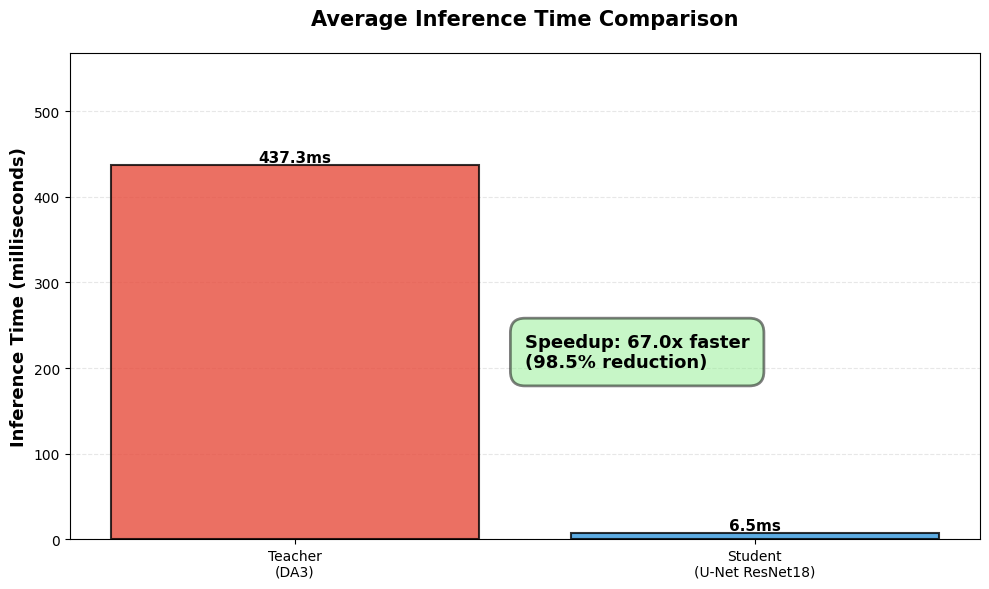


Inference Time Summary:
Teacher (DA3):
  Mean:     437.35 ms  (±571.29 ms)
  Median:   392.31 ms
  Min:      385.08 ms
  Max:     8993.05 ms

Student (U-Net ResNet18):
  Mean:       6.53 ms  (±18.12 ms)
  Median:     5.13 ms
  Min:        4.66 ms
  Max:      281.62 ms

Speedup: 67.00x faster
Time Reduction: 98.5%


In [56]:
# Calculate statistics
teacher_mean = np.mean(teacher_inference_times)
teacher_std = np.std(teacher_inference_times)
student_mean = np.mean(student_inference_times)
student_std = np.std(student_inference_times)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# ===== Bar chart comparison =====
models = ['Teacher\n(DA3)', 'Student\n(U-Net ResNet18)']
means = [teacher_mean * 1000, student_mean * 1000]  # Convert to milliseconds
stds = [teacher_std * 1000, student_std * 1000]
colors = ['#E74C3C', '#3498DB']

# CREATE THE BARS
bars = ax.bar(models, means, capsize=10, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=1.5, error_kw={'linewidth': 2})

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}ms',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Calculate speedup
speedup = teacher_mean / student_mean

# Add speedup annotation
ax.text(0.5, max(means) * 0.5,
        f'Speedup: {speedup:.1f}x faster\n({(1-student_mean/teacher_mean)*100:.1f}% reduction)',
        ha='left', va='center', fontsize=13,
        bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgreen', alpha=0.5, 
                  edgecolor='black', linewidth=2),
        fontweight='bold')

ax.set_ylabel('Inference Time (milliseconds)', fontsize=13, fontweight='bold')
ax.set_title('Average Inference Time Comparison', fontsize=15, fontweight='bold', pad=20)
ax.set_ylim(0, max(means) * 1.3)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('inference_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\nInference Time Summary:")
print("=" * 60)
print(f"Teacher (DA3):")
print(f"  Mean:   {teacher_mean*1000:>8.2f} ms  (±{teacher_std*1000:.2f} ms)")
print(f"  Median: {np.median(teacher_inference_times)*1000:>8.2f} ms")
print(f"  Min:    {np.min(teacher_inference_times)*1000:>8.2f} ms")
print(f"  Max:    {np.max(teacher_inference_times)*1000:>8.2f} ms")
print()
print(f"Student (U-Net ResNet18):")
print(f"  Mean:   {student_mean*1000:>8.2f} ms  (±{student_std*1000:.2f} ms)")
print(f"  Median: {np.median(student_inference_times)*1000:>8.2f} ms")
print(f"  Min:    {np.min(student_inference_times)*1000:>8.2f} ms")
print(f"  Max:    {np.max(student_inference_times)*1000:>8.2f} ms")
print()
print(f"Speedup: {speedup:.2f}x faster")
print(f"Time Reduction: {(1-student_mean/teacher_mean)*100:.1f}%")
print("=" * 60)